In [1]:
import polars as pl
import numpy as np
from typing import List

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # 二阶差分 = 一阶差分的差分
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")

def momentum_ratio_expr(col: str, lag: int = 200) -> pl.Expr:
    # 动量比率 = x_t / x_{t-lag}
    return (pl.col(col) / (pl.col(col).shift(lag) + 1e-8)).alias(f"{col}_momentum_ratio_{lag}")

def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")

def lag_exprs(col: str, lags: List[int]) -> List[pl.Expr]:
    return [
        pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")
        for lag in lags
    ]


def cross_comb_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) + (pl.col(b) + 1e-8)).alias(f"{a}_comb_{b}")

def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['px', 'timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_scaled')
        )
    ]

    return cols

def batch_apply_single_exprs(
        window: int,
        lag: int,
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            diff_expr(col),
            second_order_diff_expr(col),
            momentum_ratio_expr(col, lag),
            rolling_volatility_expr(col, window),
        ])
        # single_exprs.extend(lag_exprs(col, [10, 20, 50, 100, 200]))

    return single_exprs

def batch_apply_multi_exprs(
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_comb_expr(a, b),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lag: int,
        exclude_cols: List[str] = None
) -> pl.DataFrame:
    base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
   
    single_exprs = batch_apply_single_exprs(window, lag, base_cols)
    multi_exprs = batch_apply_multi_exprs(base_cols)

    exprs = single_exprs + multi_exprs
    return df_to_transforms.with_columns(single_exprs)



In [2]:
import polars as pl
import numpy as np
from typing import List
from tqdm import tqdm

def split_df_by_week(
        origin_input_df: pl.DataFrame,
        ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    origin_input_df = origin_input_df.with_columns([
        pl.col(ts_col).cast(pl.Datetime).alias(f"{ts_col}_dt")
    ])

    origin_input_df = origin_input_df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1w").alias("week_start")
    ])

    unique_weeks = origin_input_df.select("week_start").unique().sort("week_start")

    weekly_dfs = [
        origin_input_df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs


def clean_df_drop_nulls(
        df_to_clean: pl.DataFrame,
        null_threshold: int = 10000,
        verbose: bool = True
) -> pl.DataFrame:
    pd_df = df_to_clean.to_pandas()

    null_counts = pd_df.isnull().sum()
    cols_to_drop = null_counts[null_counts > null_threshold].index

    pd_df_cleaned = pd_df.drop(columns=cols_to_drop)
    pd_df_clean = pd_df_cleaned.dropna()
    pl_df_clean = pl.from_pandas(pd_df_clean)

    if verbose:
        max_null_col = null_counts.idxmax()
        max_null_count = null_counts.max()
        print("各列空值数量：")
        print(null_counts[null_counts > 0])
        print(f"删除空值超过 {null_threshold} 的列：{list(cols_to_drop)}")
        print(f"删除列后，DataFrame形状：{pd_df_cleaned.shape}")
        print(f"空值最多的列是：{max_null_col}，共有 {max_null_count} 个空值")
        print(f"删除空值行后，DataFrame形状：{pd_df_clean.shape}")

    return pl_df_clean

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> int:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

def rolling_minmax_scaled_expr(
        col: str,
        min_col: str,
        max_col: str,
        scaled_col: str
) -> pl.Expr:
    return (
        ((pl.col(col) - pl.col(min_col)) / (pl.col(max_col) - pl.col(min_col) + 1e-9))
        .clip(0.0, 1.0)
        .fill_null(0.5)
        .alias(scaled_col)
    )

def rolling_minmax_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')  # scaled 是最终产物，保留
           and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_rolling_max') or
                col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_max(window, min_samples=1).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window, min_samples=1).alias(f"{column}_rolling_min"),
        ])

    intermediate_cols = [
                            f"{column}_rolling_max" for column in columns_to_normalize
                        ] + [
                            f"{column}_rolling_min" for column in columns_to_normalize
                        ]

    return (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_minmax_scaled_expr(
                col=column,
                min_col=f"{column}_rolling_min",
                max_col=f"{column}_rolling_max",
                scaled_col=f"{column}_scaled"
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )

def rolling_mean_tanh_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window, min_samples=1)
        .tanh()
        .rolling_mean(window, min_samples=1)
        .alias(scaled_col)
    )

def rolling_mean_tanh_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_tanh_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_normalize
    ])

def rolling_ic_ir_icto_index(
        df: pl.DataFrame,
        target_col: str,
        exclude_prefixes: list[str],
        window_size: int,
        step: int = 1,
) -> pl.DataFrame:
    feature_cols = [
        col for col in df.columns
        if col.endswith("_scaled") 
            and col.startswith("z_") 
            and all(not col.startswith(prefix) for prefix in exclude_prefixes)
            and not col.startswith("future_return_")
            and col != "px"
    ]

    # feature_cols = [
    #     col for col in df.columns
    #     if col.startswith("z_") 
    #         and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    #         and not col.startswith("future_return_")
    #         and col != "px"
    # ]

    n = df.height
    results = []
    prev_ranks = {}

    for start in tqdm(range(0, n - window_size + 1, step), desc="Rolling IC & ICTO"):
        end = start + window_size
        df_win = df.slice(start, window_size)

        # rank 转换
        df_ranked = df_win.with_columns([
            (pl.col(c).rank(method="average") / window_size).alias(c + "_rank") for c in feature_cols + [target_col]
        ])
        target_rank_col = target_col + "_rank"

        for feat in feature_cols:
            feat_rank_col = feat + "_rank"
            ic = df_ranked.select(
                pl.corr(pl.col(feat_rank_col), pl.col(target_rank_col)).alias("ic")
            ).to_series()[0]

            turnover = None
            if feat in prev_ranks:
                cur_ranks = df_ranked[feat_rank_col].to_numpy()
                prev = prev_ranks[feat]
                if len(prev) == len(cur_ranks):
                    turnover = np.mean(np.abs(cur_ranks - prev))

            # 更新 prev_ranks
            prev_ranks[feat] = df_ranked[feat_rank_col].to_numpy()

            results.append({
                "window_start": int(start),
                "window_end": int(end - 1),
                "factor": str(feat),
                "ic": float(ic) if not np.isnan(ic) else None,
                "turnover": float(turnover) if turnover is not None else None
            })

    df_result = pl.DataFrame(
        results,
        schema={
            "window_start": pl.Int64,
            "window_end": pl.Int64,
            "factor": pl.Utf8,
            "ic": pl.Float64,
            "turnover": pl.Float64,
        }
    )      
    return (
        df_result
        .group_by("factor")
        .agg([
            pl.mean("ic").alias("mean_ic"),
            pl.std("ic").alias("std_ic"),
            pl.mean("turnover").alias("mean_turnover")
        ])
        .with_columns([
            (pl.col("mean_ic") / pl.col("std_ic")).alias("ir"),
            (pl.col("mean_ic") / (pl.col("mean_turnover") + 1e-8)).abs().alias("icto")
        ])
        .sort("icto", descending=True)
    )

In [49]:
origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/BTCUSDT_factors_threshold0.001_rolling200.csv")
print(origin_df)
origin_df = batch_apply_transforms(origin_df, 200, 1)
origin_df = rolling_mean_tanh_normalize(origin_df, 200)

shape: (27_214, 115)
┌──────────────────┬──────────┬────────────┬─────────────┬───┬─────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ timestamp        ┆ px       ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_factor_momentum_t ┆ z_factor_order_sen ┆ z_factor_oi_moment ┆ z_factor_oi_moment │
│ ---              ┆ ---      ┆ ---        ┆ ---         ┆   ┆ rend_confir…        ┆ timent_diver…      ┆ um_punch           ┆ um_long_term…      │
│ i64              ┆ f64      ┆ f64        ┆ f64         ┆   ┆ ---                 ┆ ---                ┆ ---                ┆ ---                │
│                  ┆          ┆            ┆             ┆   ┆ f64                 ┆ f64                ┆ f64                ┆ f64                │
╞══════════════════╪══════════╪════════════╪═════════════╪═══╪═════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ 1744003134974000 ┆ 77116.4  ┆ 41.241     ┆ 18.209      ┆ … ┆ 0.759049            ┆ -0.668

In [313]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.mixture import GaussianMixture

import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.preprocessing import LabelEncoder
import torch

import numpy as np
import matplotlib.pyplot as plt

In [55]:
exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = "future_std_label"

feature_cols = [
    col for col in origin_df.columns
    if col.endswith("_scaled") 
        and all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "px"
]
print(feature_cols[-20:])

['z_factor_oi_breakout_signal_diff_1_scaled', 'z_factor_oi_breakout_signal_second_order_diff_1_scaled', 'z_factor_oi_breakout_signal_momentum_ratio_1_scaled', 'z_factor_oi_breakout_signal_volatility_200_scaled', 'z_factor_momentum_trend_confirm_diff_1_scaled', 'z_factor_momentum_trend_confirm_second_order_diff_1_scaled', 'z_factor_momentum_trend_confirm_momentum_ratio_1_scaled', 'z_factor_momentum_trend_confirm_volatility_200_scaled', 'z_factor_order_sentiment_divergence_diff_1_scaled', 'z_factor_order_sentiment_divergence_second_order_diff_1_scaled', 'z_factor_order_sentiment_divergence_momentum_ratio_1_scaled', 'z_factor_order_sentiment_divergence_volatility_200_scaled', 'z_factor_oi_momentum_punch_diff_1_scaled', 'z_factor_oi_momentum_punch_second_order_diff_1_scaled', 'z_factor_oi_momentum_punch_momentum_ratio_1_scaled', 'z_factor_oi_momentum_punch_volatility_200_scaled', 'z_factor_oi_momentum_long_term_punch_diff_1_scaled', 'z_factor_oi_momentum_long_term_punch_second_order_diff_1

In [269]:
def plot_last_n_rows_with_px(y_test, y_test_binary, y_pred_prob, px, std_array=None, n=700, m=-1, alpha=1):
    # 截取最后 n 行
    y_test_slice = y_test[n:m]
    y_test_binary_slice = y_test_binary[n:m]
    y_pred_prob_slice = y_pred_prob[n:m]
    px_slice = px[n:m]
    
    if std_array is not None:
        std_slice = std_array[n:m]
    else:
        std_slice = None

    time_index = np.arange(len(y_test_slice))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # # 原始收益
    # ax1.plot(time_index, y_test_slice, label="Original Future Returns", color='gray', alpha=0.8)
    # ax1.set_ylabel("Original Future Returns", color='gray')
    # ax1.tick_params(axis='y', labelcolor='gray')

    # GMM 标签
    ax2 = ax1.twinx()
    ax2.scatter(time_index, y_test_binary_slice, label="GMM Labels", color='tab:blue', marker='o', s=20, alpha=0.7)
    ax2.set_ylabel("GMM Labels (0 or 1)", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(-0.1, 1.1)

    # 模型预测概率
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(time_index, y_pred_prob_slice, label="MODEL Predicted Probability", color='tab:green', alpha=0.4)
    ax3.set_ylabel("MODEL Predicted Probability", color='tab:green')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.set_ylim(-0.05, 1.05)

    # 价格线 (第4轴)
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))  # 再右移一层
    ax4.plot(time_index, px_slice, label="Price (px)", color='tab:blue', linestyle='--', alpha=0.6)

    # 加上下轨线
    if std_slice is not None:
        ax4.plot(time_index, px_slice + alpha * std_slice, label="Price + std", color='tab:gray', linestyle=':', alpha=0.4)
        ax4.plot(time_index, px_slice - alpha * std_slice, label="Price - std", color='tab:gray', linestyle=':', alpha=0.4)

    ax4.set_ylabel("Price (px)", color='tab:red')
    ax4.tick_params(axis='y', labelcolor='tab:red')

    # x轴
    ax1.set_xlabel("Time Index")
    plt.title(f"Compare Returns, Labels, Prediction & Price (Last {n} Rows)")

    # 图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    lines_4, labels_4 = ax4.get_legend_handles_labels()

    ax1.legend(
        lines_1 + lines_2 + lines_3 + lines_4,
        labels_1 + labels_2 + labels_3 + labels_4,
        loc='upper left'
    )

    plt.tight_layout()
    plt.show()


In [225]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def evaluate_with_confidence(
    y_true,
    y_pred_proba,                      
    model_name="Model",                    
    lower_thresh=0.15,                  
    upper_thresh=0.85,       
    print_report=True,
):

    # ===== 基础评估 (全样本) =====
    base_pred = (y_pred_proba >= 0.5).astype(int)
    base_acc = accuracy_score(y_true, base_pred)
    
    # ===== 置信预测评估 =====
    # 生成交易信号 (-1: 不交易, 0: 做空, 1: 做多)
    signals = np.full_like(y_pred_proba, fill_value=-1, dtype=int)
    signals[y_pred_proba <= lower_thresh] = 0
    signals[y_pred_proba >= upper_thresh] = 1
    
    # 计算置信预测指标
    mask = signals != -1
    conf_acc = accuracy_score(y_true[mask], signals[mask]) if any(mask) else np.nan
    trading_rate = mask.mean()
    
    # ===== 结果组织 =====
    eval_dict = {
        'model': model_name,
        'thresholds': f"{lower_thresh}-{upper_thresh}",
        'base_accuracy': base_acc,
        'confident_accuracy': conf_acc,
        'trading_rate': trading_rate,
        'conf_matrix': confusion_matrix(y_true[mask], signals[mask]) if any(mask) else None,
        'class_report': classification_report(y_true[mask], signals[mask], output_dict=True) if any(mask) else None,
        'y_test_binary': y_true, 
        'y_pred_proba': y_pred_proba, 
        'signal': signals,
    }
    
    # ===== 打印输出 =====
    if print_report:
        print(f"\n=== {model_name} 评估结果 ===")
        print(f"📊 全样本准确率: {base_acc:.4f}")
        print(f"✅ 自信预测准确率: {conf_acc:.4f} (阈值 {lower_thresh}-{upper_thresh})")
        print(f"📈 出手率: {trading_rate:.2%}")
        
        if any(mask):
            print("\n🧮 自信预测混淆矩阵:")
            print(eval_dict['conf_matrix'])
            
            print("\n📝 分类报告:")
            print(classification_report(y_true[mask], signals[mask]))
        else:
            print("⚠️ 无自信预测样本!")
    
    return eval_dict


In [279]:
import polars as pl
import numpy as np
from tqdm import tqdm

rolling_window = 150     
alpha = 2

a_df = (
    origin_df
    .with_columns([
        pl.col("px").rolling_std(window_size=rolling_window).alias("rolling_std"),
    ])
)

def label_by_future_std(px: np.ndarray, std: np.ndarray) -> np.ndarray:
    n = len(px)
    labels = np.full(n, -1)  # 初始化为 -1（未触发）

    for i in tqdm(range(n), desc="Labeling by future std"):
        anchor_price = px[i]
        for j in range(i + 1, n):
            upper_bound = anchor_price + alpha * std[j]
            lower_bound = anchor_price - alpha * std[j]
            if px[j] >= upper_bound:
                labels[i] = 1
                break
            elif px[j] <= lower_bound:
                labels[i] = 0
                break

            else:
                labels[i] = -1

    return labels

px_np = a_df["px"].to_numpy()
std_np = a_df["rolling_std"].to_numpy()

labels_np = label_by_future_std(px_np, std_np)

a_df = a_df.with_columns(pl.Series("future_std_label", labels_np))
print(a_df)
a_df_filtered = a_df.filter(pl.col("future_std_label") >= 0)
print(a_df_filtered)
a_df_filtered = clean_df_drop_nulls(a_df_filtered)

weekly_dataframes = split_df_by_week(a_df_filtered)
print("num weekly dfs: ", len(weekly_dataframes))

Labeling by future std: 100%|████████████████████████████████████████████████████████████████████████████| 27214/27214 [00:00<00:00, 34613.98it/s]


shape: (27_214, 1_134)
┌──────────────────┬──────────┬────────────┬─────────────┬───┬─────────────────────────┬─────────────────────────┬─────────────┬──────────────────┐
│ timestamp        ┆ px       ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_factor_oi_momentum_lo ┆ z_factor_oi_momentum_lo ┆ rolling_std ┆ future_std_label │
│ ---              ┆ ---      ┆ ---        ┆ ---         ┆   ┆ ng_term…                ┆ ng_term…                ┆ ---         ┆ ---              │
│ i64              ┆ f64      ┆ f64        ┆ f64         ┆   ┆ ---                     ┆ ---                     ┆ f64         ┆ i64              │
│                  ┆          ┆            ┆             ┆   ┆ f64                     ┆ f64                     ┆             ┆                  │
╞══════════════════╪══════════╪════════════╪═════════════╪═══╪═════════════════════════╪═════════════════════════╪═════════════╪══════════════════╡
│ 1744003134974000 ┆ 77116.4  ┆ 41.241     ┆ 18.209      ┆ … ┆ null                    ┆ 

Fold 0: Train 0~4, Val 5, Test 6
Train: 2025-04-07 07:05:18.143000 to 2025-05-11 23:57:01.156000
Val: 2025-05-12 00:05:11.740000 to 2025-05-18 23:59:34.191000
Test: 2025-05-19 00:00:37.074000 to 2025-05-25 23:57:24.031000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 6972929300496384.0|  0:00:00s
epoch 5  | loss: 5393136484352.0|  0:00:02s
epoch 10 | loss: 1205287723008.0|  0:00:04s
epoch 15 | loss: 1297971527680.0|  0:00:06s
epoch 20 | loss: 607968169984.0|  0:00:07s
epoch 25 | loss: 532463951872.00006|  0:00:09s
epoch 30 | loss: 370305458176.0|  0:00:11s
epoch 35 | loss: 291664558080.0|  0:00:13s
epoch 40 | loss: 341468865536.0|  0:00:15s
epoch 45 | loss: 179847552000.0|  0:00:17s
epoch 50 | loss: 209677840384.0|  0:00:19s
epoch 55 | loss: 109876471808.0|  0:00:21s
epoch 60 | loss: 114164908032.0|  0:00:23s
epoch 65 | loss: 122433286656.0|  0:00:25s
epoch 70 | loss: 120099548672.0|  0:00:27s
epoch 75 | loss: 113807916032.0|  0:00:29s
epoch 80 | loss: 132859898880.0|  0:00:31s
epoch 85 | loss: 50989594624.0|  0:00:33s
epoch 90 | loss: 72305808384.0|  0:00:35s
epoch 95 | loss: 64594876800.0|  0:00:37s
epoch 100| loss: 73814941440.0|  0:00:39s
epoch 105| loss: 41261057024.0|  0:00:40s
epoch 110| loss: 55787976960.0|  0:00:42s
epoch 

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 8 to 16
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 8 to 16
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.70466 | val_0_accuracy: 0.54619 |  0:00:00s
epoch 5  | loss: 0.65446 | val_0_accuracy: 0.58952 |  0:00:04s
epoch 10 | loss: 0.6372  | val_0_accuracy: 0.52333 |  0:00:07s
epoch 15 | loss: 0.6309  | val_0_accuracy: 0.42524 |  0:00:11s
epoch 20 | loss: 0.61855 | val_0_accuracy: 0.46286 |  0:00:15s
epoch 25 | loss: 0.6192  | val_0_accuracy: 0.45476 |  0:00:18s
epoch 30 | loss: 0.60409 | val_0_accuracy: 0.43048 |  0:00:22s
epoch 35 | loss: 0.59875 | val_0_accuracy: 0.41048 |  0:00:25s
epoch 40 | loss: 0.57857 | val_0_accuracy: 0.37095 |  0:00:29s
epoch 45 | loss: 0.56728 | val_0_accuracy: 0.44619 |  0:00:33s
epoch 50 | loss: 0.55231 | val_0_accuracy: 0.4381  |  0:00:37s
epoch 55 | loss: 0.54526 | val_0_accuracy: 0.44905 |  0:00:40s

Early stopping occurred at epoch 55 with best_epoch = 5 and best_val_0_accuracy = 0.58952


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.5895
✅ 自信预测准确率: 0.6958 (阈值 0.2-0.8)
📈 出手率: 14.71%

🧮 自信预测混淆矩阵:
[[ 68  15]
 [ 79 147]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.46      0.82      0.59        83
           1       0.91      0.65      0.76       226

    accuracy                           0.70       309
   macro avg       0.68      0.73      0.67       309
weighted avg       0.79      0.70      0.71       309



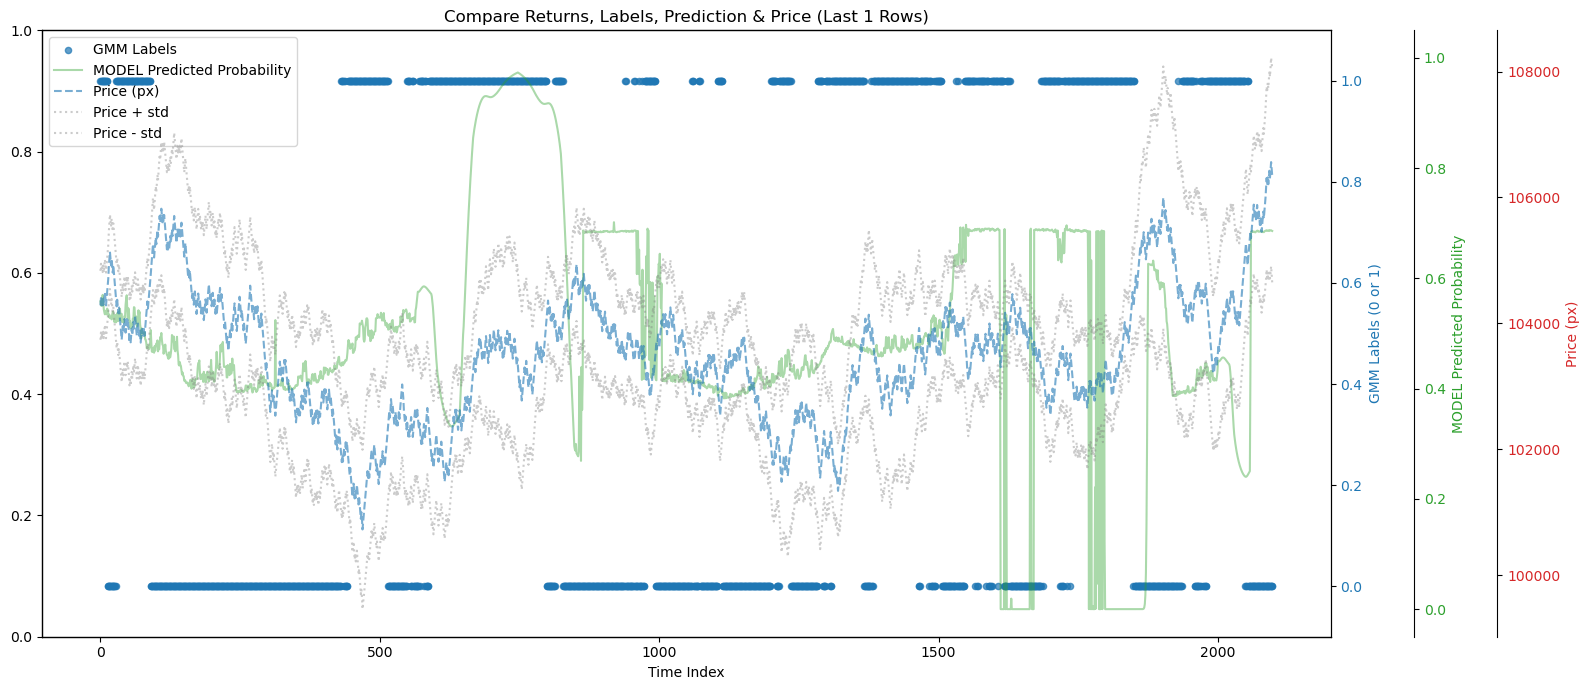

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.


=== tabnet 评估结果 ===
📊 全样本准确率: 0.3613
✅ 自信预测准确率: 0.1429 (阈值 0.2-0.8)
📈 出手率: 4.30%

🧮 自信预测混淆矩阵:
[[  0 120]
 [  0  20]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.14      1.00      0.25        20

    accuracy                           0.14       140
   macro avg       0.07      0.50      0.12       140
weighted avg       0.02      0.14      0.04       140



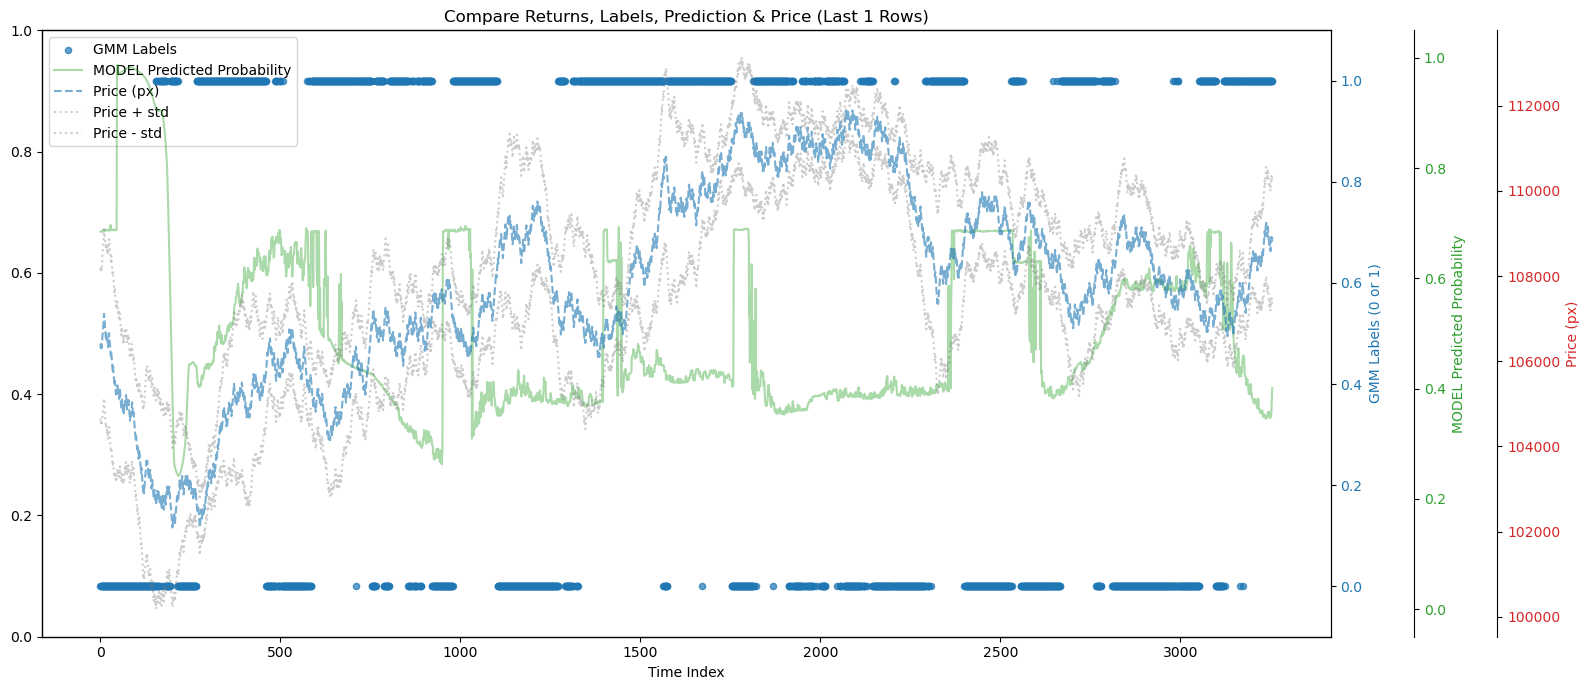

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68925 | val_0_accuracy: 0.46952 |  0:00:00s
epoch 5  | loss: 0.41673 | val_0_accuracy: 0.47095 |  0:00:04s
epoch 10 | loss: 0.33417 | val_0_accuracy: 0.4619  |  0:00:08s
epoch 15 | loss: 0.29194 | val_0_accuracy: 0.53095 |  0:00:12s
epoch 20 | loss: 0.28435 | val_0_accuracy: 0.53143 |  0:00:16s
epoch 25 | loss: 0.26631 | val_0_accuracy: 0.51048 |  0:00:20s
epoch 30 | loss: 0.27423 | val_0_accuracy: 0.47429 |  0:00:23s
epoch 35 | loss: 0.2465  | val_0_accuracy: 0.54095 |  0:00:27s
epoch 40 | loss: 0.24103 | val_0_accuracy: 0.49429 |  0:00:31s
epoch 45 | loss: 0.23422 | val_0_accuracy: 0.47667 |  0:00:34s
epoch 50 | loss: 0.22997 | val_0_accuracy: 0.50429 |  0:00:38s
epoch 55 | loss: 0.22107 | val_0_accuracy: 0.47429 |  0:00:42s
epoch 60 | loss: 0.21993 | val_0_accuracy: 0.53333 |  0:00:46s
epoch 65 | loss: 0.21974 | val_0_accuracy: 0.57429 |  0:00:49s
epoch 70 | loss: 0.23354 | val_0_accuracy: 0.51905 |  0:00:53s
epoch 75 | loss: 0.20618 | val_0_accuracy: 0.53952 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5771
✅ 自信预测准确率: 0.5858 (阈值 0.2-0.8)
📈 出手率: 73.00%

🧮 自信预测混淆矩阵:
[[444 364]
 [271 454]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.62      0.55      0.58       808
           1       0.56      0.63      0.59       725

    accuracy                           0.59      1533
   macro avg       0.59      0.59      0.59      1533
weighted avg       0.59      0.59      0.59      1533



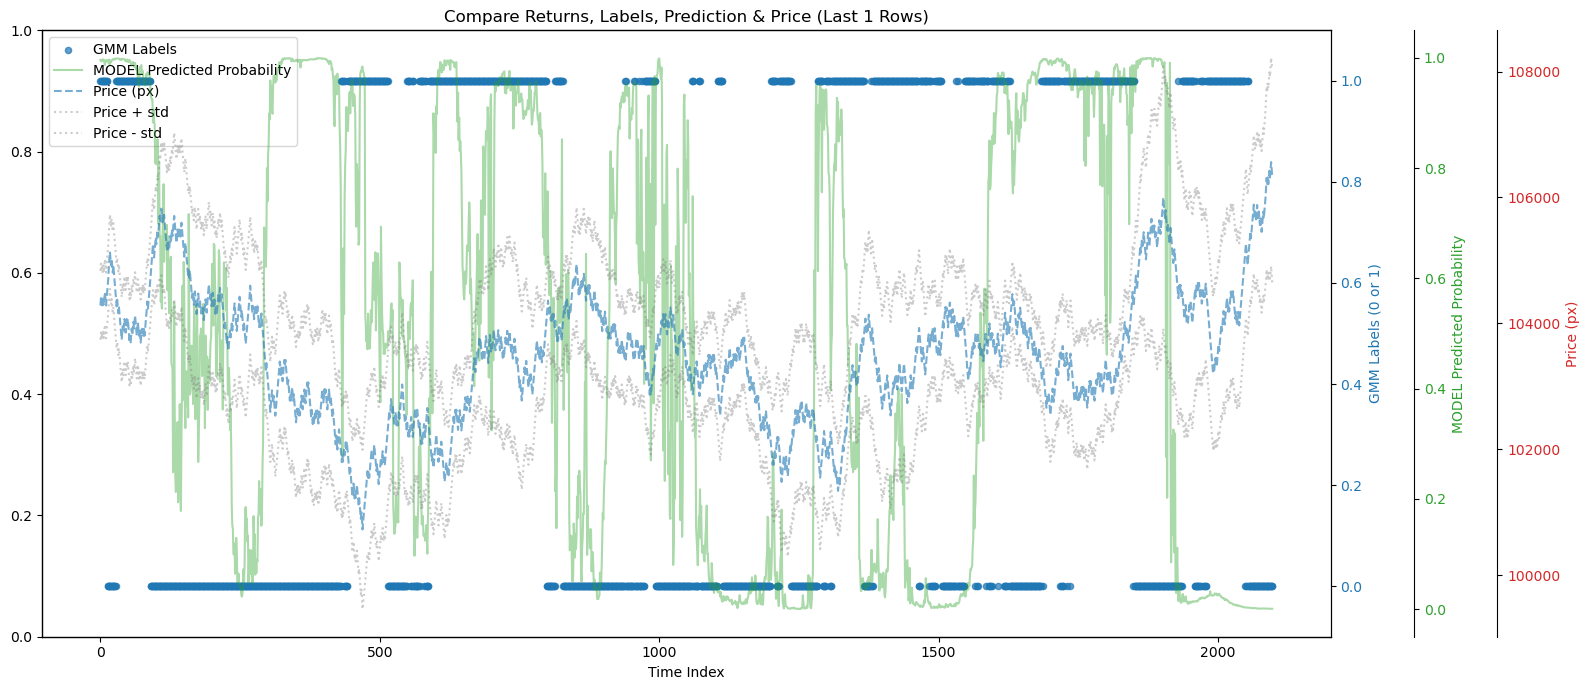

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.3613
✅ 自信预测准确率: 0.1429 (阈值 0.2-0.8)
📈 出手率: 4.30%

🧮 自信预测混淆矩阵:
[[  0 120]
 [  0  20]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.14      1.00      0.25        20

    accuracy                           0.14       140
   macro avg       0.07      0.50      0.12       140
weighted avg       0.02      0.14      0.04       140



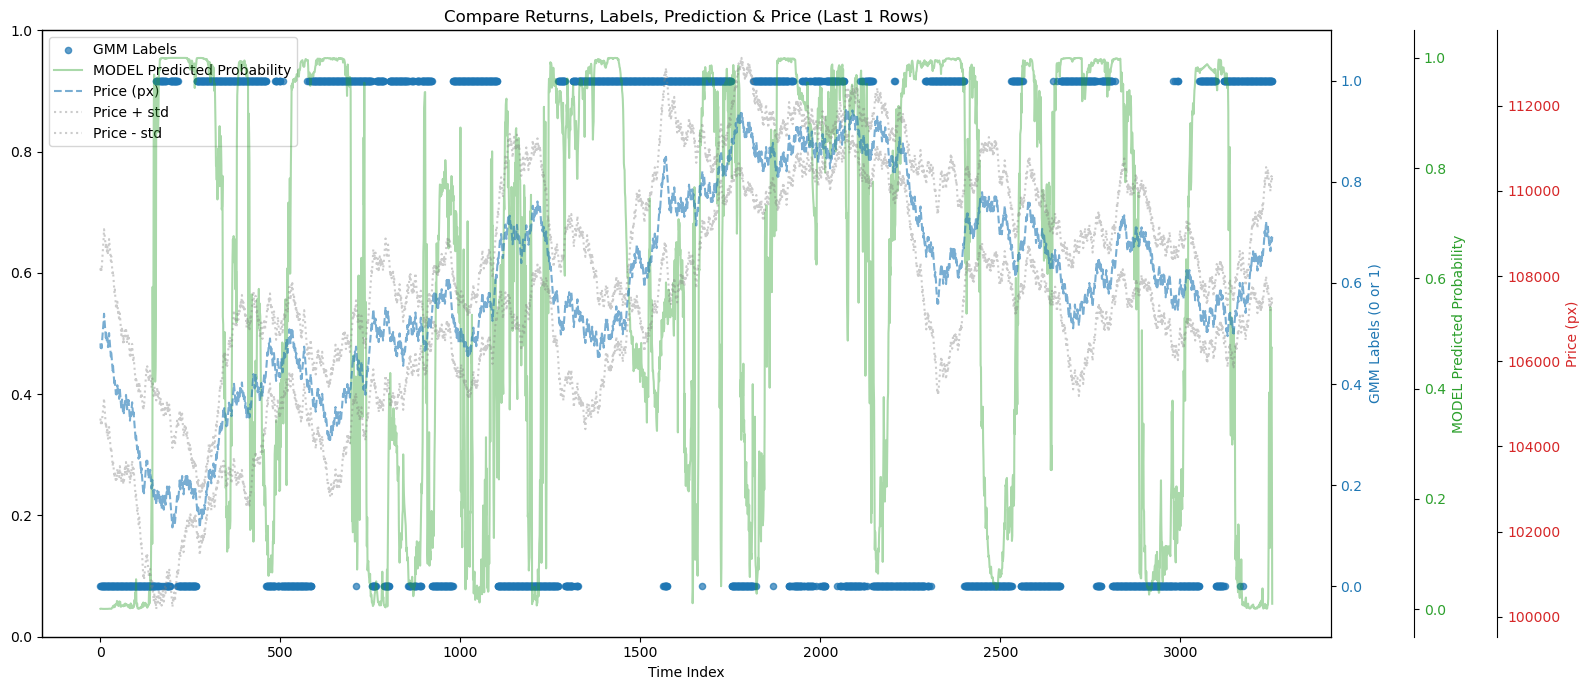

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.71535 |  0:00:00s
epoch 5  | loss: 0.37749 |  0:00:00s
epoch 10 | loss: 0.29136 |  0:00:00s
epoch 15 | loss: 0.25399 |  0:00:01s
epoch 20 | loss: 0.24867 |  0:00:01s
epoch 25 | loss: 0.23281 |  0:00:01s
epoch 30 | loss: 0.22323 |  0:00:02s
epoch 35 | loss: 0.20099 |  0:00:02s
epoch 40 | loss: 0.20083 |  0:00:03s
epoch 45 | loss: 0.20769 |  0:00:03s
epoch 50 | loss: 0.18793 |  0:00:03s
epoch 55 | loss: 0.18866 |  0:00:04s
epoch 60 | loss: 0.16794 |  0:00:04s
epoch 65 | loss: 0.15996 |  0:00:04s
epoch 70 | loss: 0.17141 |  0:00:05s
epoch 75 | loss: 0.15043 |  0:00:05s
epoch 80 | loss: 0.16346 |  0:00:06s
epoch 85 | loss: 0.14978 |  0:00:06s
epoch 90 | loss: 0.14965 |  0:00:06s
epoch 95 | loss: 0.1461  |  0:00:07s
Test Week 5 Evaluation Completed
Fold 1: Train 1~5, Val 6, Test 7
Train: 2025-04-14 00:03:18.378000 to 2025-05-18 23:59:34.191000
Val: 2025-05-19 00:00:37.074000 to 2025-05-25 23:57:24.031000
Test: 2025-05-26 00:01:11.960000 to 2025-06-01 23:52:35.215000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 8 to 16
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 8 to 16
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.78084 | val_0_accuracy: 0.42142 |  0:00:00s
epoch 5  | loss: 0.64879 | val_0_accuracy: 0.37078 |  0:00:03s
epoch 10 | loss: 0.62016 | val_0_accuracy: 0.35114 |  0:00:05s
epoch 15 | loss: 0.60785 | val_0_accuracy: 0.36341 |  0:00:07s
epoch 20 | loss: 0.59524 | val_0_accuracy: 0.44199 |  0:00:10s
epoch 25 | loss: 0.59177 | val_0_accuracy: 0.53161 |  0:00:12s
epoch 30 | loss: 0.54743 | val_0_accuracy: 0.49417 |  0:00:14s
epoch 35 | loss: 0.52135 | val_0_accuracy: 0.49141 |  0:00:17s
epoch 40 | loss: 0.52233 | val_0_accuracy: 0.50399 |  0:00:19s
epoch 45 | loss: 0.5049  | val_0_accuracy: 0.54174 |  0:00:21s
epoch 50 | loss: 0.47841 | val_0_accuracy: 0.50921 |  0:00:24s
epoch 55 | loss: 0.45525 | val_0_accuracy: 0.52977 |  0:00:26s
epoch 60 | loss: 0.46674 | val_0_accuracy: 0.55003 |  0:00:28s
epoch 65 | loss: 0.45187 | val_0_accuracy: 0.50675 |  0:00:30s
epoch 70 | loss: 0.43355 | val_0_accuracy: 0.53376 |  0:00:33s
epoch 75 | loss: 0.44046 | val_0_accuracy: 0.53039 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.5648
✅ 自信预测准确率: 0.4225 (阈值 0.2-0.8)
📈 出手率: 34.44%

🧮 自信预测混淆矩阵:
[[420  44]
 [604  54]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.41      0.91      0.56       464
           1       0.55      0.08      0.14       658

    accuracy                           0.42      1122
   macro avg       0.48      0.49      0.35      1122
weighted avg       0.49      0.42      0.32      1122



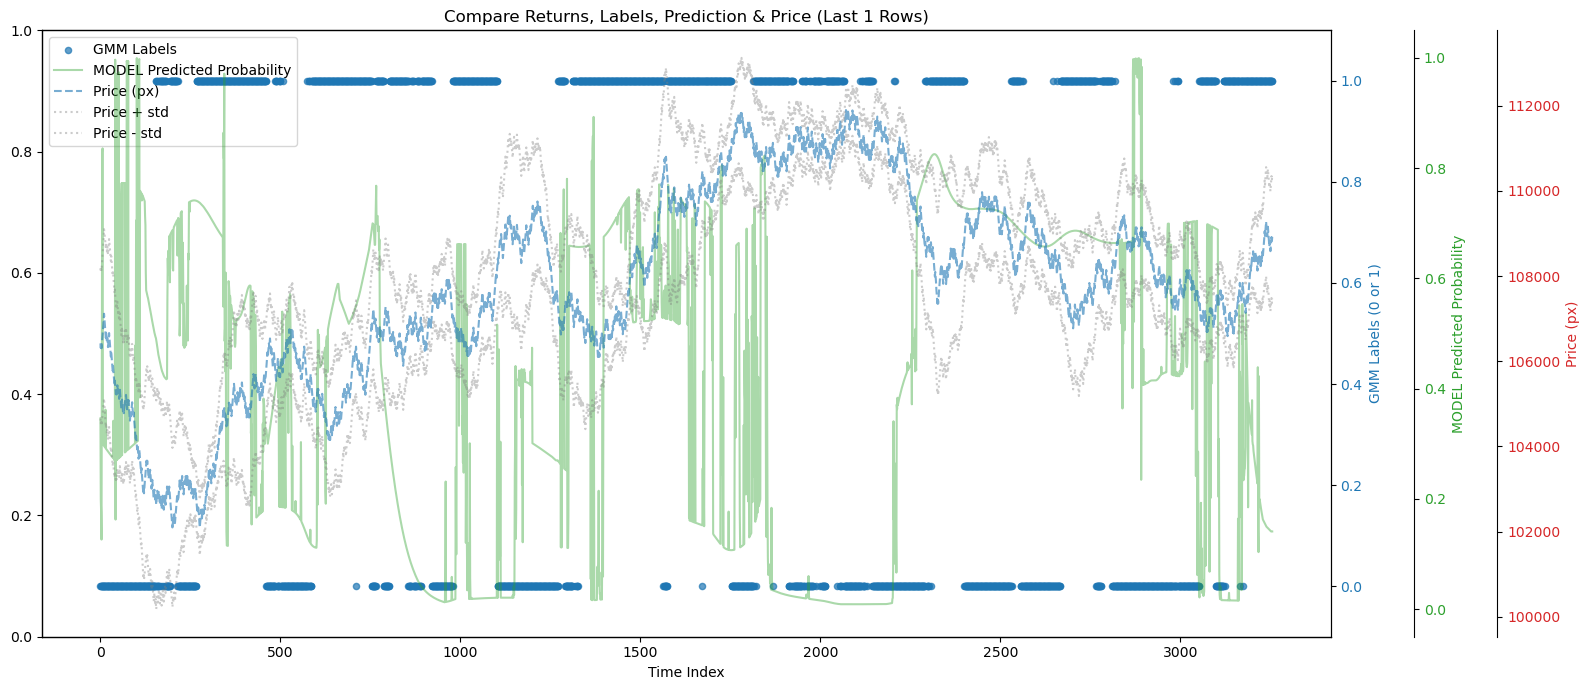


=== tabnet 评估结果 ===
📊 全样本准确率: 0.3735
✅ 自信预测准确率: 0.3592 (阈值 0.2-0.8)
📈 出手率: 41.93%

🧮 自信预测混淆矩阵:
[[270 277]
 [269  36]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.50      0.49      0.50       547
           1       0.12      0.12      0.12       305

    accuracy                           0.36       852
   macro avg       0.31      0.31      0.31       852
weighted avg       0.36      0.36      0.36       852



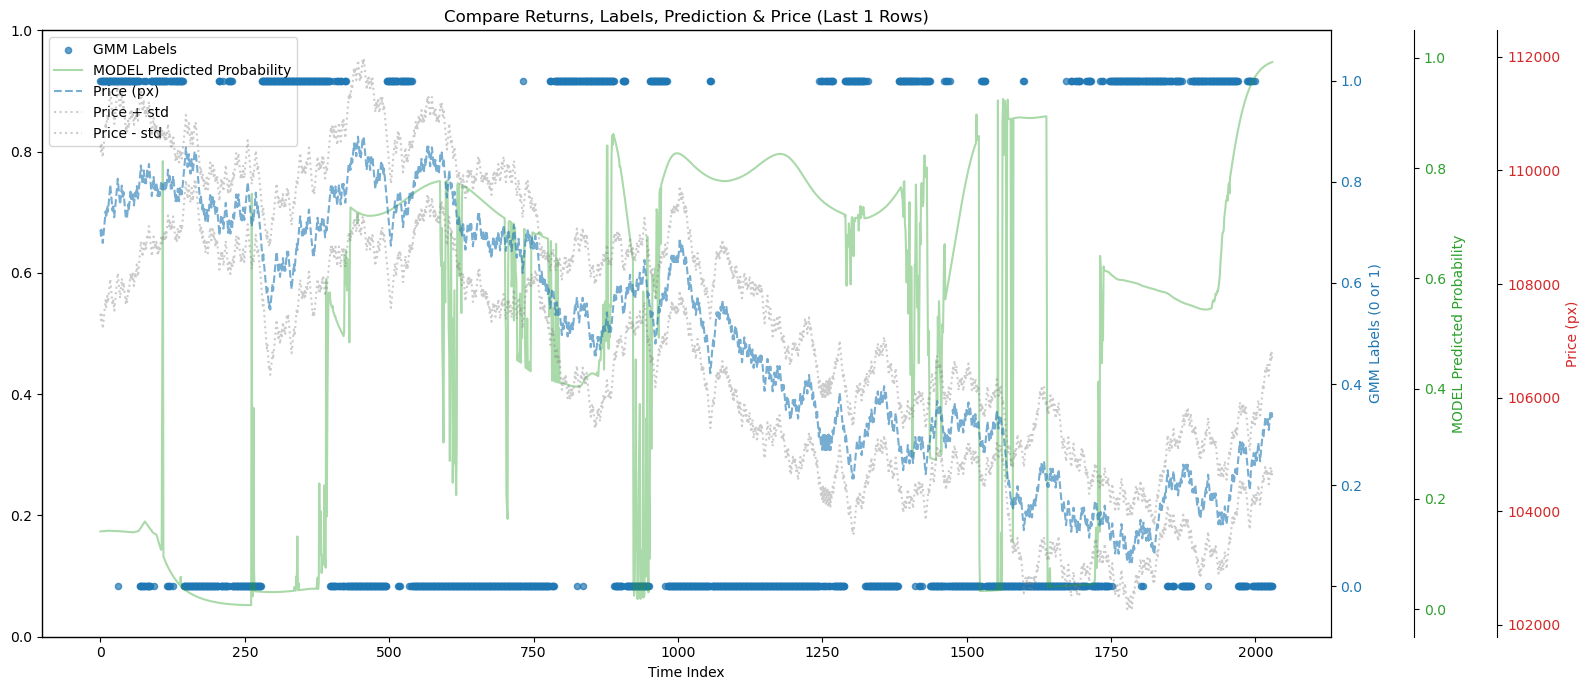

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.49329 |  0:00:00s
epoch 5  | loss: 0.31987 |  0:00:00s
epoch 10 | loss: 0.26778 |  0:00:01s
epoch 15 | loss: 0.21572 |  0:00:01s
epoch 20 | loss: 0.19909 |  0:00:02s
epoch 25 | loss: 0.20558 |  0:00:03s
epoch 30 | loss: 0.18926 |  0:00:03s
epoch 35 | loss: 0.17003 |  0:00:04s
epoch 40 | loss: 0.17648 |  0:00:04s
epoch 45 | loss: 0.16661 |  0:00:05s
epoch 50 | loss: 0.16211 |  0:00:05s
epoch 55 | loss: 0.14551 |  0:00:06s
epoch 60 | loss: 0.16337 |  0:00:07s
epoch 65 | loss: 0.16026 |  0:00:07s
epoch 70 | loss: 0.15143 |  0:00:08s
epoch 75 | loss: 0.15911 |  0:00:08s
epoch 80 | loss: 0.13757 |  0:00:09s
epoch 85 | loss: 0.15048 |  0:00:09s
epoch 90 | loss: 0.13002 |  0:00:10s
epoch 95 | loss: 0.13112 |  0:00:11s

=== tab_inc 评估结果 ===
📊 全样本准确率: 0.9490
✅ 自信预测准确率: 0.9795 (阈值 0.2-0.8)
📈 出手率: 89.81%

🧮 自信预测混淆矩阵:
[[1314   24]
 [  36 1552]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1338
           1      

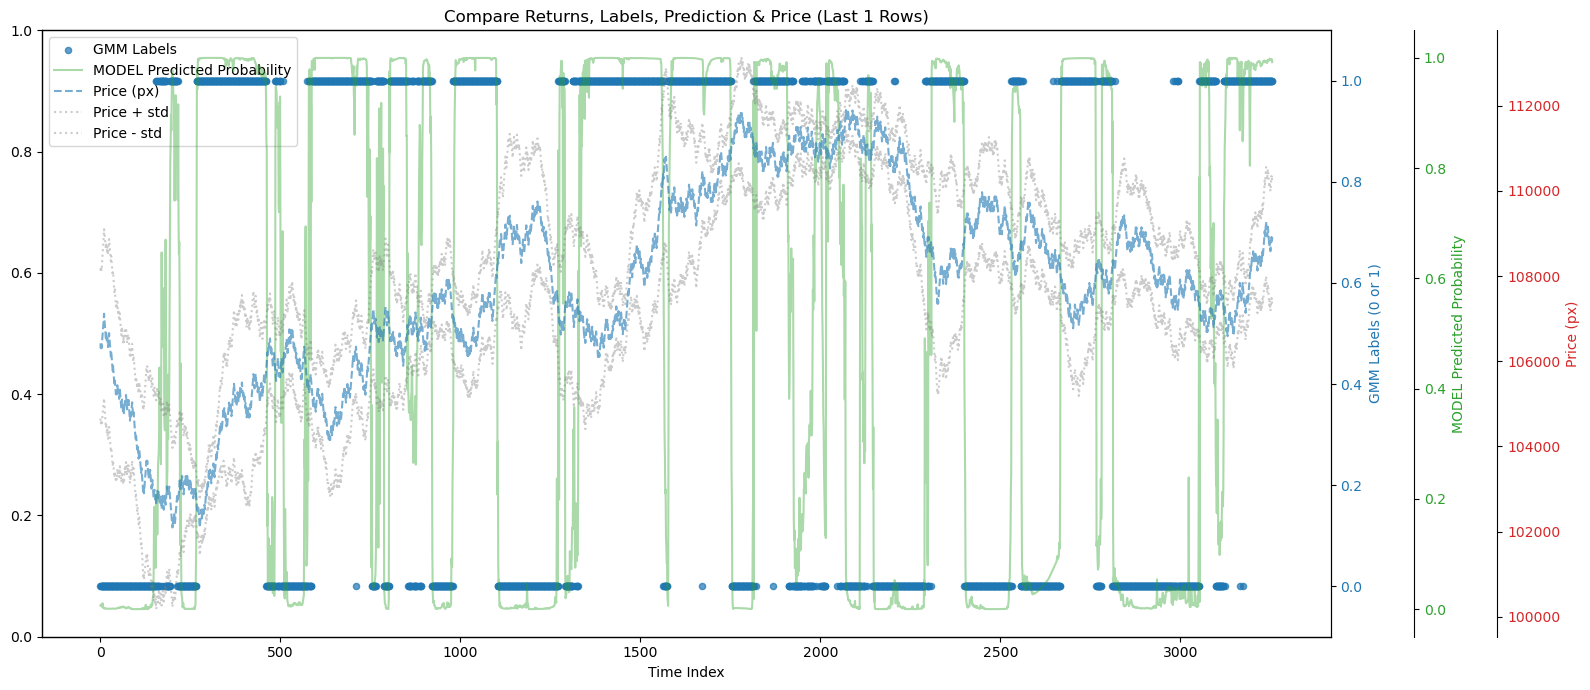


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5044
✅ 自信预测准确率: 0.4962 (阈值 0.2-0.8)
📈 出手率: 76.87%

🧮 自信预测混淆矩阵:
[[426 532]
 [255 349]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.63      0.44      0.52       958
           1       0.40      0.58      0.47       604

    accuracy                           0.50      1562
   macro avg       0.51      0.51      0.49      1562
weighted avg       0.54      0.50      0.50      1562



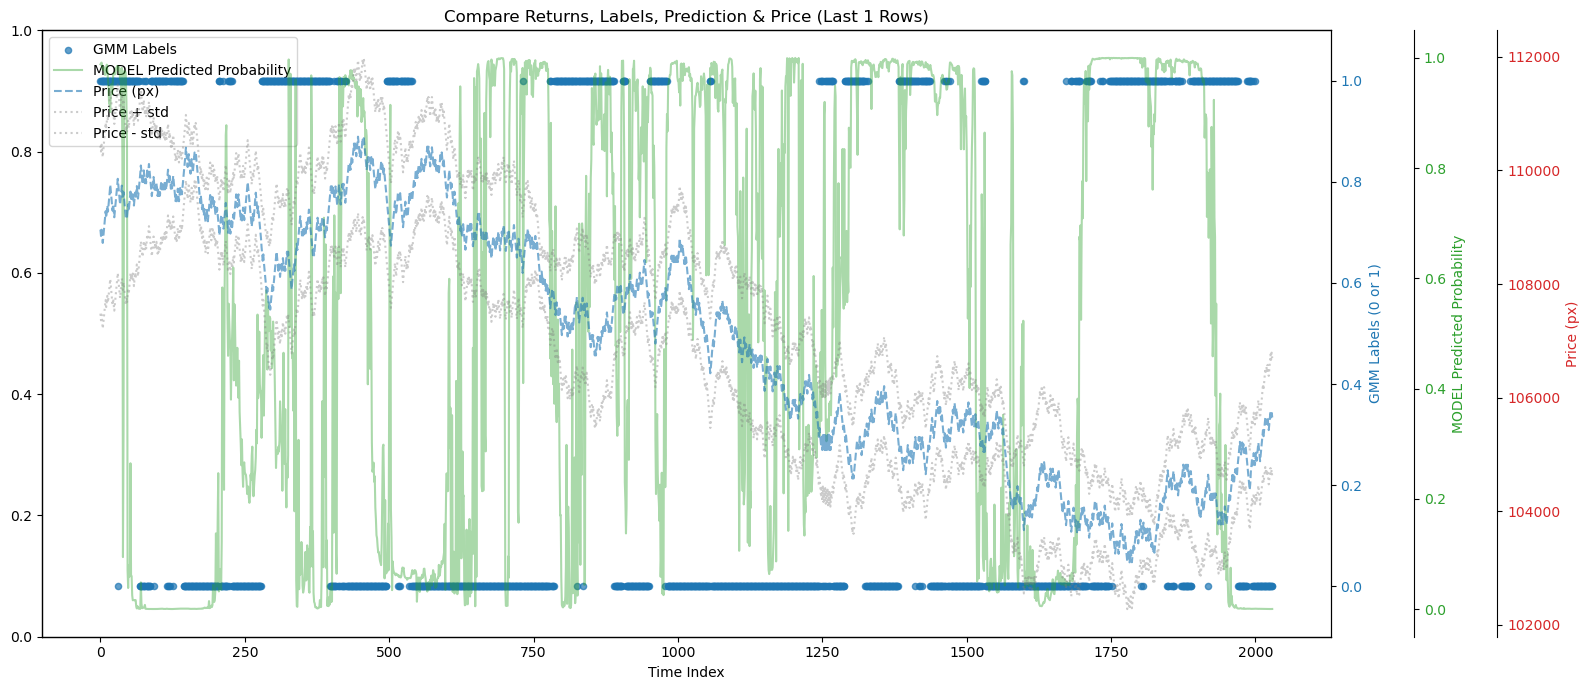

Test Week 6 Evaluation Completed
Fold 2: Train 2~6, Val 7, Test 8
Train: 2025-04-21 00:06:22.525000 to 2025-05-25 23:57:24.031000
Val: 2025-05-26 00:01:11.960000 to 2025-06-01 23:52:35.215000
Test: 2025-06-02 00:06:44.065000 to 2025-06-08 23:58:17.188000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 8 to 16
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 8 to 16
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.77181 | val_0_accuracy: 0.55364 |  0:00:00s
epoch 5  | loss: 0.64183 | val_0_accuracy: 0.59203 |  0:00:03s
epoch 10 | loss: 0.59999 | val_0_accuracy: 0.53396 |  0:00:05s
epoch 15 | loss: 0.60342 | val_0_accuracy: 0.61122 |  0:00:08s
epoch 20 | loss: 0.58148 | val_0_accuracy: 0.57382 |  0:00:11s
epoch 25 | loss: 0.582   | val_0_accuracy: 0.51033 |  0:00:13s
epoch 30 | loss: 0.56643 | val_0_accuracy: 0.48278 |  0:00:16s
epoch 35 | loss: 0.56292 | val_0_accuracy: 0.49656 |  0:00:18s
epoch 40 | loss: 0.51721 | val_0_accuracy: 0.47736 |  0:00:21s
epoch 45 | loss: 0.5054  | val_0_accuracy: 0.4247  |  0:00:23s
epoch 50 | loss: 0.49394 | val_0_accuracy: 0.4065  |  0:00:26s

Early stopping occurred at epoch 54 with best_epoch = 4 and best_val_0_accuracy = 0.63337


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetr


=== tabnet 评估结果 ===
📊 全样本准确率: 0.6334
✅ 自信预测准确率: 0.6526 (阈值 0.2-0.8)
📈 出手率: 72.39%

🧮 自信预测混淆矩阵:
[[960   0]
 [511   0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       960
           1       0.00      0.00      0.00       511

    accuracy                           0.65      1471
   macro avg       0.33      0.50      0.39      1471
weighted avg       0.43      0.65      0.52      1471



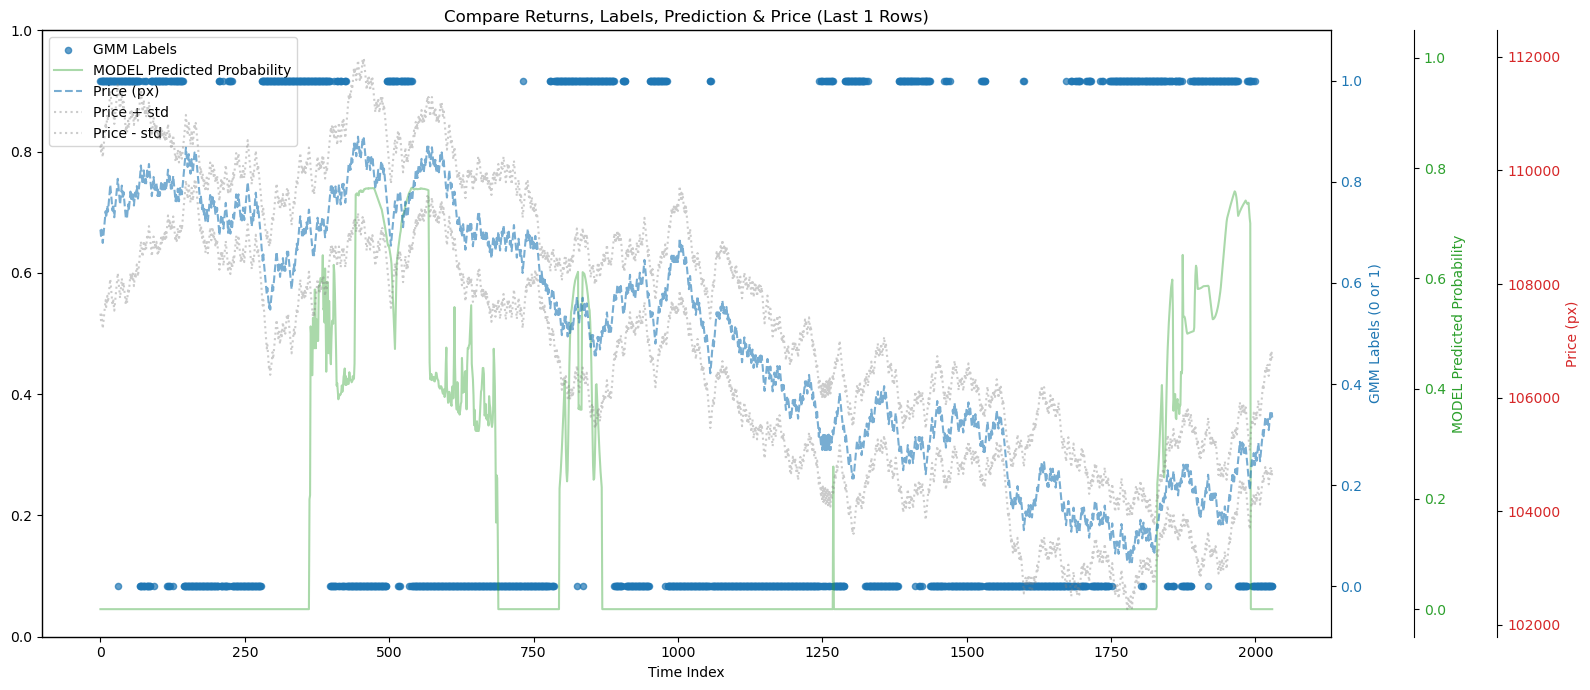

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.


=== tabnet 评估结果 ===
📊 全样本准确率: 0.3918
✅ 自信预测准确率: 0.3877 (阈值 0.2-0.8)
📈 出手率: 98.50%

🧮 自信预测混淆矩阵:
[[609   0]
 [962   0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.39      1.00      0.56       609
           1       0.00      0.00      0.00       962

    accuracy                           0.39      1571
   macro avg       0.19      0.50      0.28      1571
weighted avg       0.15      0.39      0.22      1571



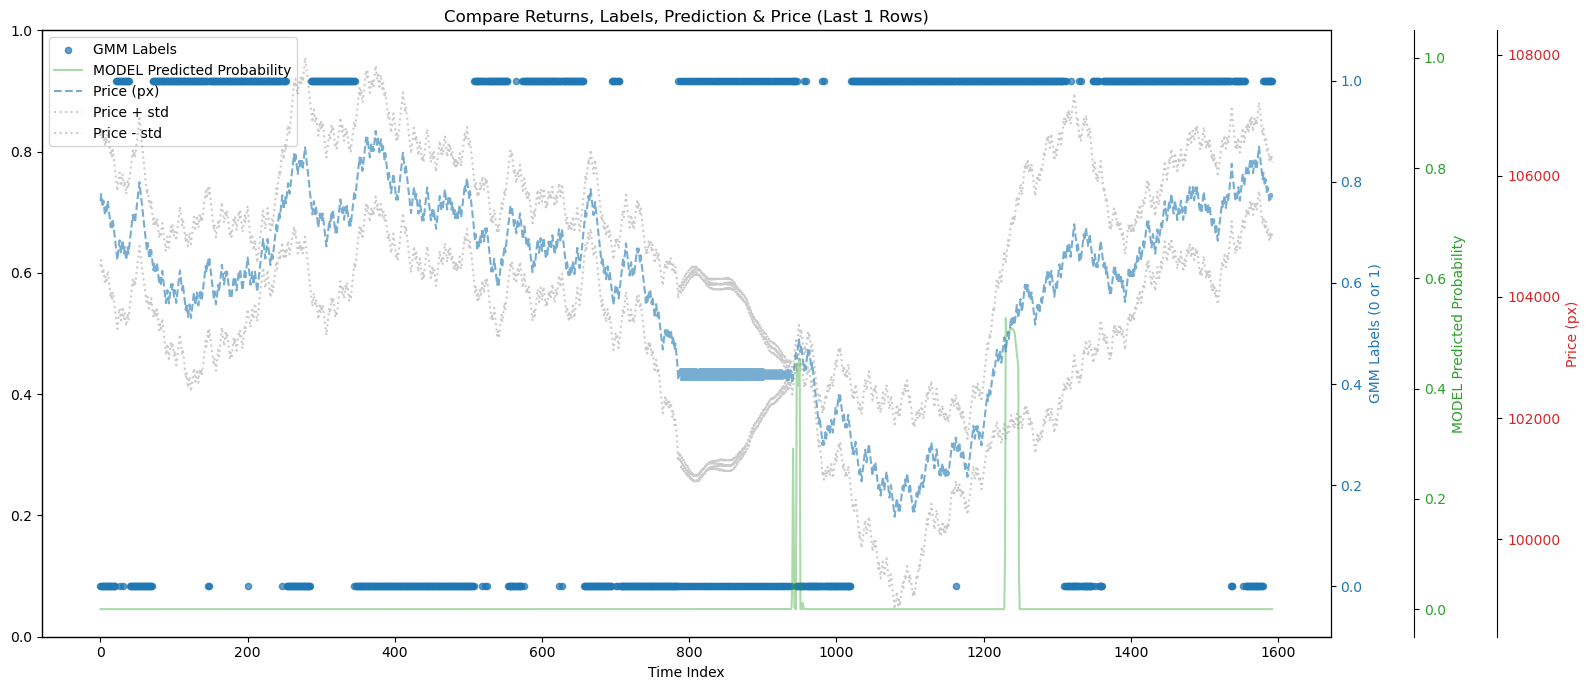

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.67633 |  0:00:00s
epoch 5  | loss: 0.52289 |  0:00:00s
epoch 10 | loss: 0.386   |  0:00:00s
epoch 15 | loss: 0.37091 |  0:00:00s
epoch 20 | loss: 0.30234 |  0:00:00s
epoch 25 | loss: 0.33427 |  0:00:00s
epoch 30 | loss: 0.30378 |  0:00:01s
epoch 35 | loss: 0.28681 |  0:00:01s
epoch 40 | loss: 0.26764 |  0:00:01s
epoch 45 | loss: 0.26147 |  0:00:01s
epoch 50 | loss: 0.26055 |  0:00:01s
epoch 55 | loss: 0.23881 |  0:00:02s
epoch 60 | loss: 0.24692 |  0:00:02s
epoch 65 | loss: 0.23473 |  0:00:02s
epoch 70 | loss: 0.23113 |  0:00:02s
epoch 75 | loss: 0.21477 |  0:00:02s
epoch 80 | loss: 0.20878 |  0:00:02s
epoch 85 | loss: 0.20651 |  0:00:03s
epoch 90 | loss: 0.2059  |  0:00:03s
epoch 95 | loss: 0.19217 |  0:00:03s

=== tab_inc 评估结果 ===
📊 全样本准确率: 0.8804
✅ 自信预测准确率: 0.9403 (阈值 0.2-0.8)
📈 出手率: 79.92%

🧮 自信预测混淆矩阵:
[[1080   15]
 [  82  447]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1095
           1      

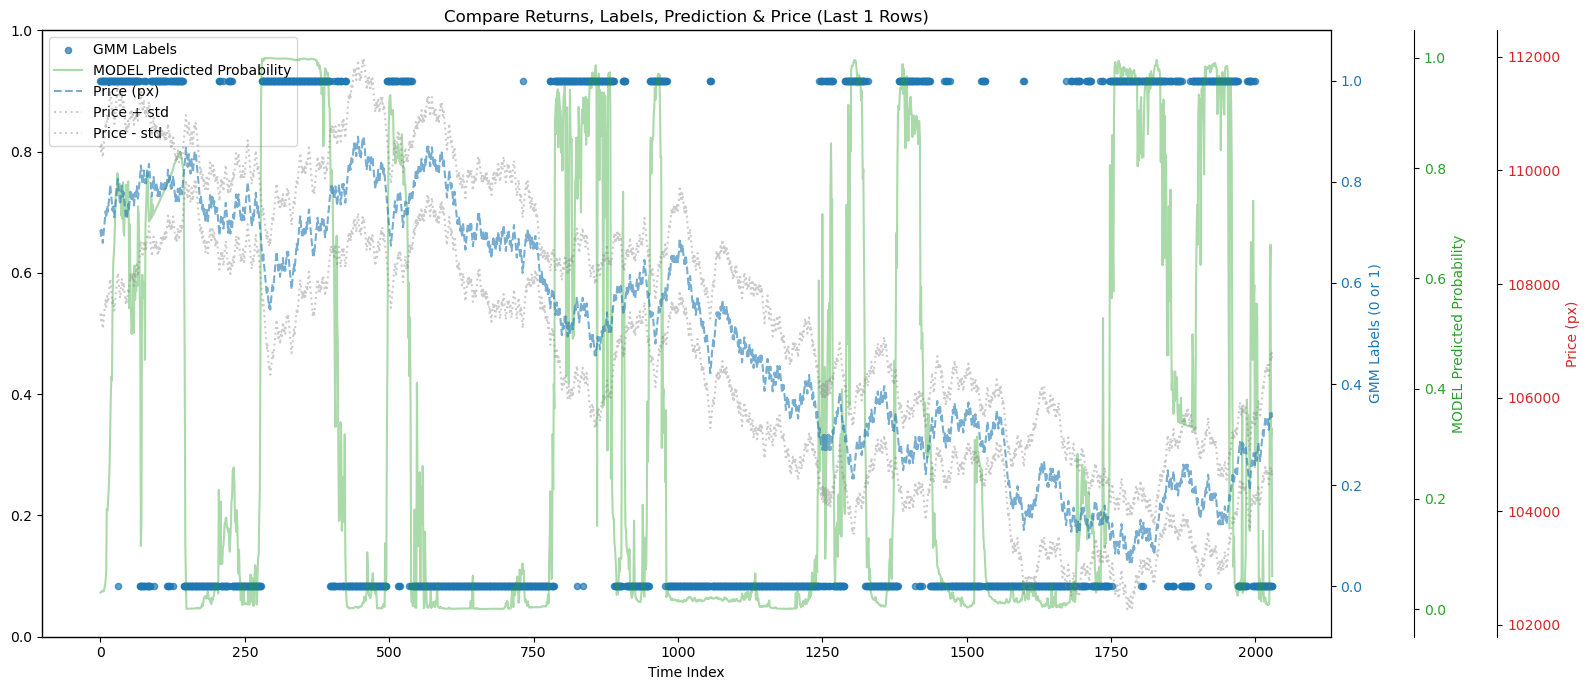


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.4313
✅ 自信预测准确率: 0.3885 (阈值 0.2-0.8)
📈 出手率: 80.69%

🧮 自信预测混淆矩阵:
[[380  50]
 [737 120]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.34      0.88      0.49       430
           1       0.71      0.14      0.23       857

    accuracy                           0.39      1287
   macro avg       0.52      0.51      0.36      1287
weighted avg       0.58      0.39      0.32      1287



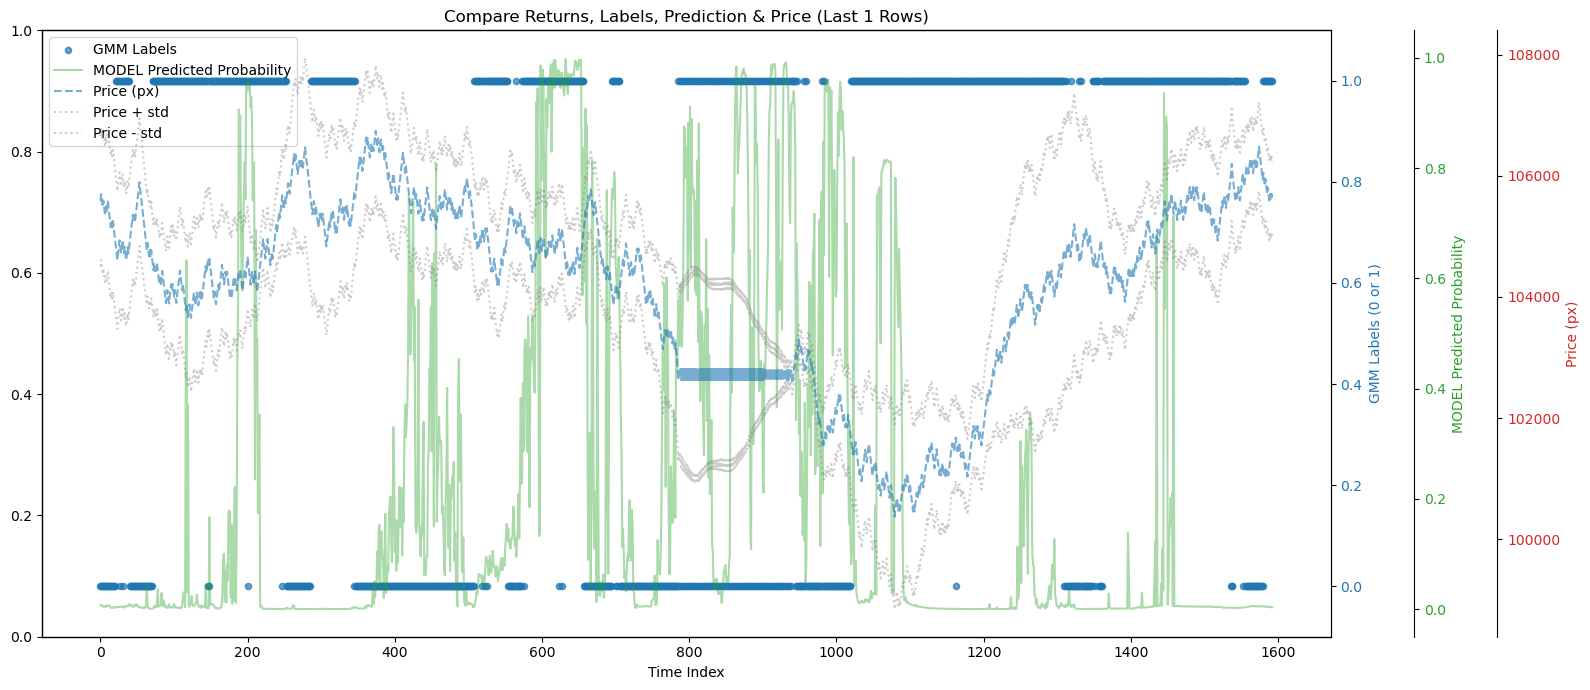

Test Week 7 Evaluation Completed
Fold 3: Train 3~7, Val 8, Test 9
Train: 2025-04-28 00:06:59.957000 to 2025-06-01 23:52:35.215000
Val: 2025-06-02 00:06:44.065000 to 2025-06-08 23:58:17.188000
Test: 2025-06-09 00:07:03.215000 to 2025-06-10 19:40:05.930000


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_a changed from 8 to 16
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:118: UserWarning: Pretraining: n_d changed from 8 to 16
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.72142 | val_0_accuracy: 0.67586 |  0:00:00s
epoch 5  | loss: 0.65609 | val_0_accuracy: 0.5185  |  0:00:02s
epoch 10 | loss: 0.62768 | val_0_accuracy: 0.43009 |  0:00:04s
epoch 15 | loss: 0.62773 | val_0_accuracy: 0.46458 |  0:00:07s
epoch 20 | loss: 0.60442 | val_0_accuracy: 0.52665 |  0:00:09s
epoch 25 | loss: 0.58225 | val_0_accuracy: 0.5442  |  0:00:11s
epoch 30 | loss: 0.56745 | val_0_accuracy: 0.44514 |  0:00:13s
epoch 35 | loss: 0.55666 | val_0_accuracy: 0.45141 |  0:00:15s
epoch 40 | loss: 0.56347 | val_0_accuracy: 0.43135 |  0:00:18s
epoch 45 | loss: 0.5485  | val_0_accuracy: 0.42571 |  0:00:20s
epoch 50 | loss: 0.52372 | val_0_accuracy: 0.46771 |  0:00:22s

Early stopping occurred at epoch 50 with best_epoch = 0 and best_val_0_accuracy = 0.67586


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.6759
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


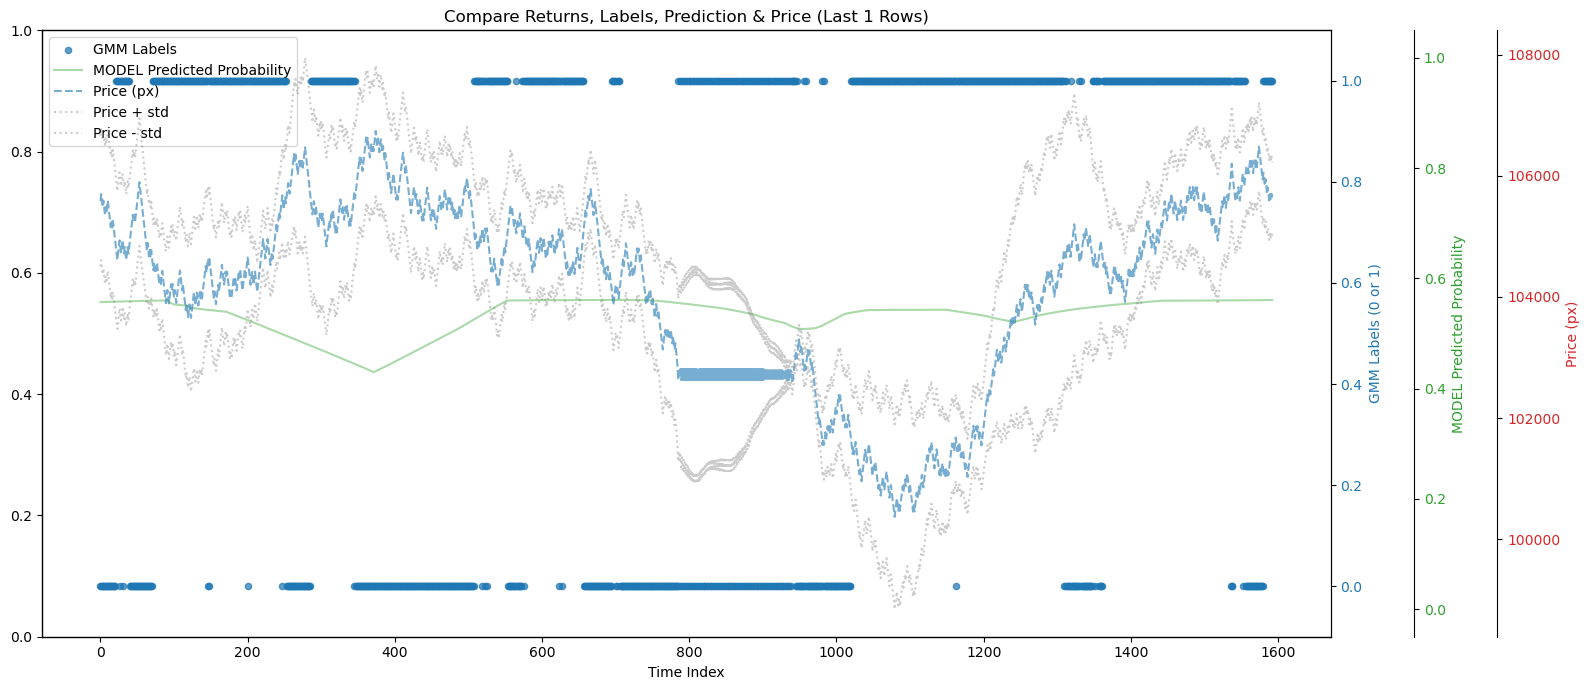


=== tabnet 评估结果 ===
📊 全样本准确率: 0.6399
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


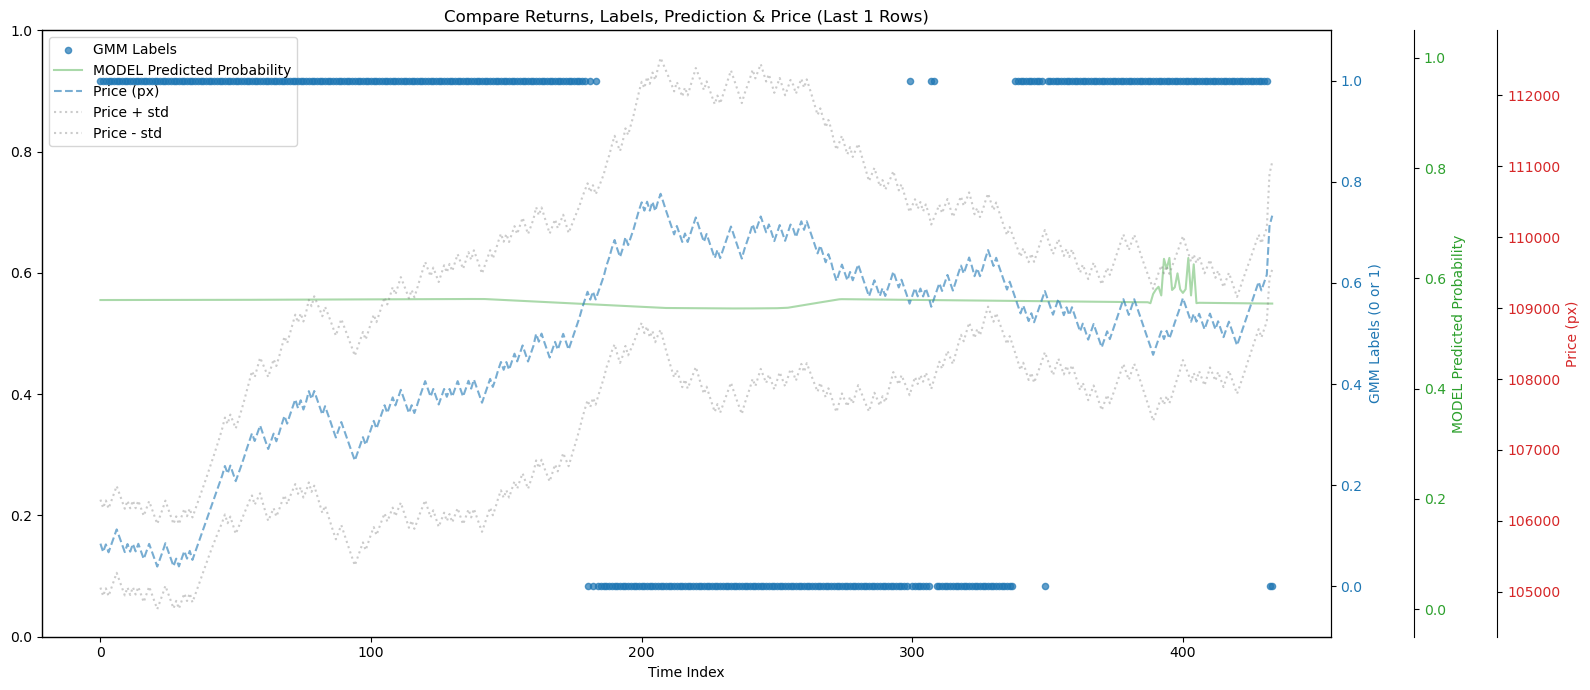

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.00625 |  0:00:00s
epoch 5  | loss: 0.49844 |  0:00:00s
epoch 10 | loss: 0.37898 |  0:00:00s
epoch 15 | loss: 0.36024 |  0:00:00s
epoch 20 | loss: 0.33108 |  0:00:00s
epoch 25 | loss: 0.34968 |  0:00:00s
epoch 30 | loss: 0.29245 |  0:00:01s
epoch 35 | loss: 0.30924 |  0:00:01s
epoch 40 | loss: 0.2891  |  0:00:01s
epoch 45 | loss: 0.27595 |  0:00:01s
epoch 50 | loss: 0.26305 |  0:00:01s
epoch 55 | loss: 0.2424  |  0:00:02s
epoch 60 | loss: 0.26805 |  0:00:02s
epoch 65 | loss: 0.24082 |  0:00:02s
epoch 70 | loss: 0.23232 |  0:00:02s
epoch 75 | loss: 0.22465 |  0:00:02s
epoch 80 | loss: 0.21562 |  0:00:02s
epoch 85 | loss: 0.27675 |  0:00:03s
epoch 90 | loss: 0.25632 |  0:00:03s
epoch 95 | loss: 0.23687 |  0:00:03s

=== tab_inc 评估结果 ===
📊 全样本准确率: 0.8614
✅ 自信预测准确率: 0.9545 (阈值 0.2-0.8)
📈 出手率: 73.04%

🧮 自信预测混淆矩阵:
[[378  21]
 [ 32 734]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       399
           1       0.9

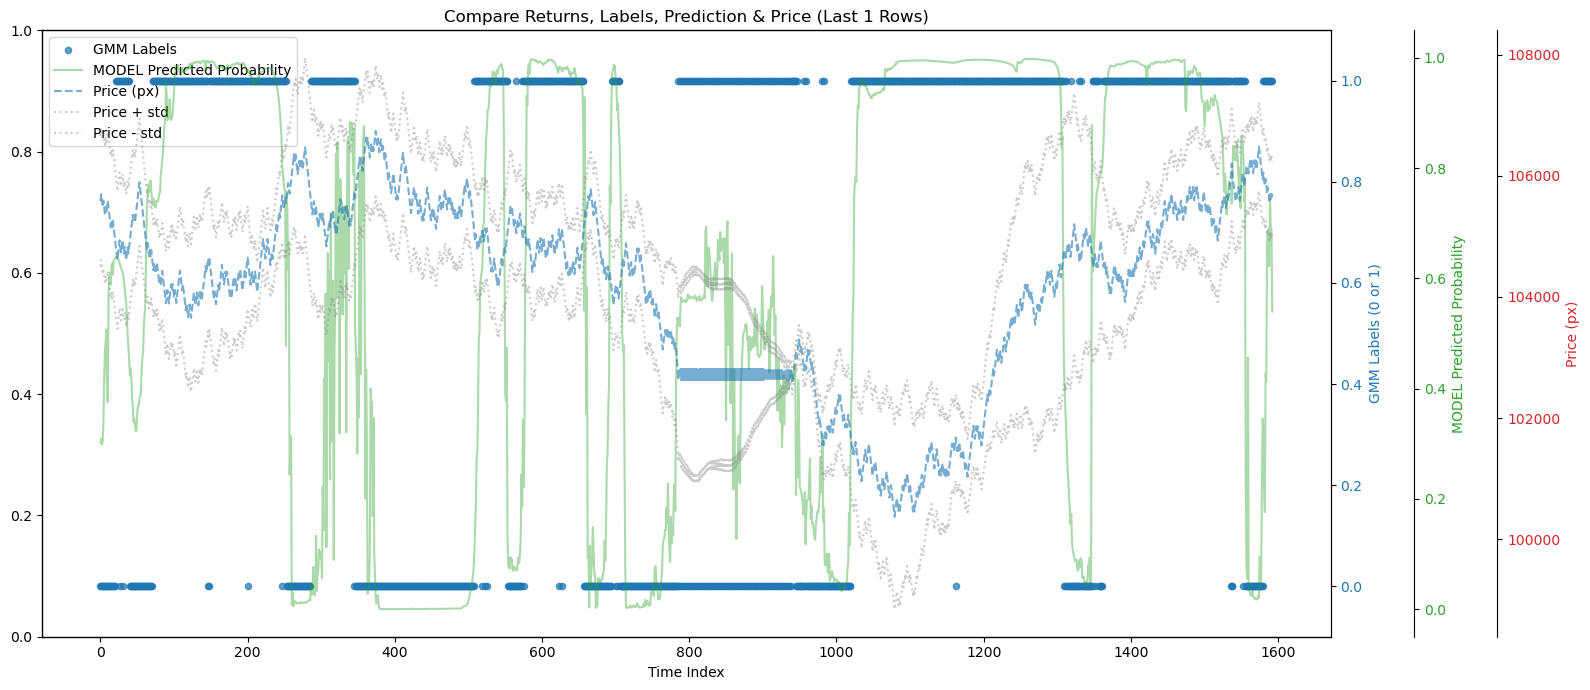


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6835
✅ 自信预测准确率: 0.6943 (阈值 0.2-0.8)
📈 出手率: 72.02%

🧮 自信预测混淆矩阵:
[[ 76  40]
 [ 56 142]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.58      0.66      0.61       116
           1       0.78      0.72      0.75       198

    accuracy                           0.69       314
   macro avg       0.68      0.69      0.68       314
weighted avg       0.70      0.69      0.70       314



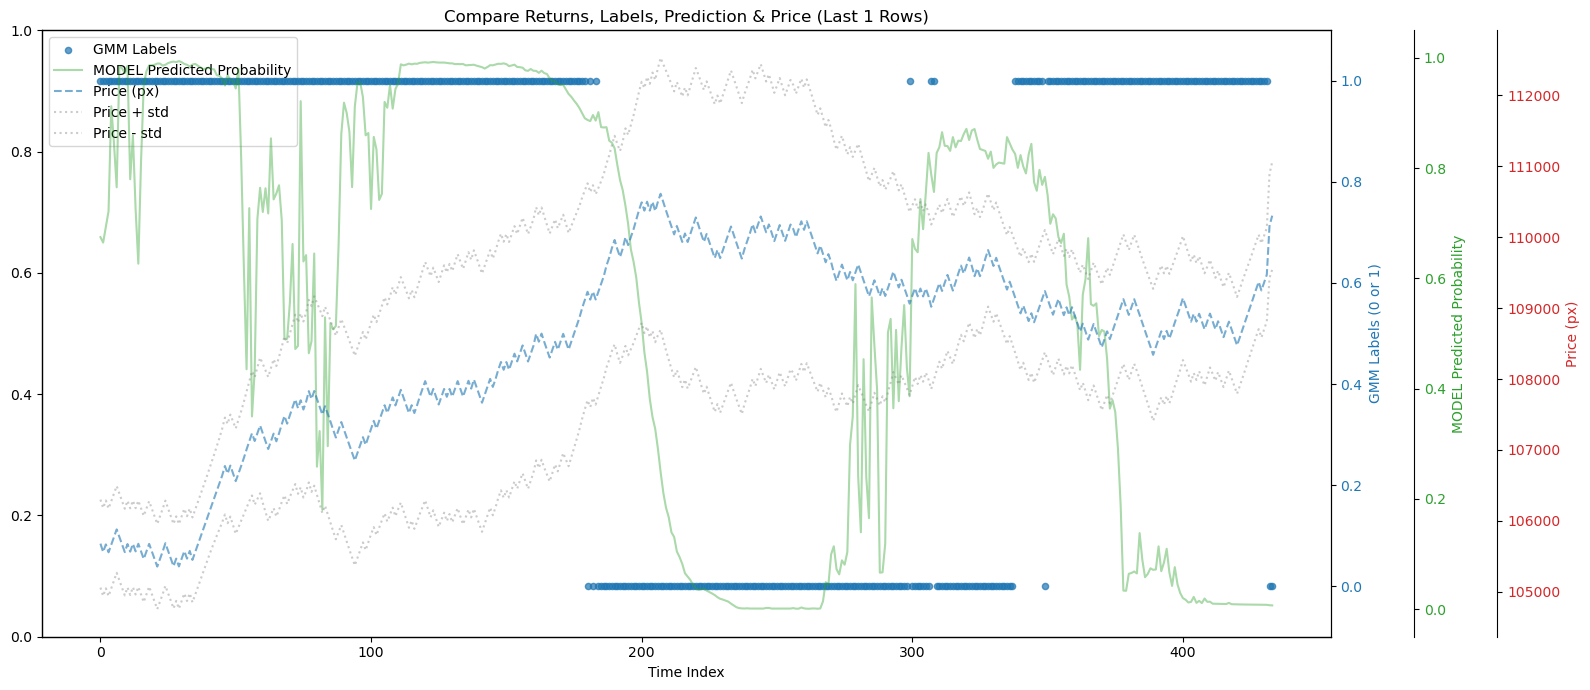

Test Week 8 Evaluation Completed

--- Final Predictions DataFrame for Backtesting ---
          timestamp   symbol  true_label  predicted_prob        px  \
0  1747612837074000  BTCUSDT           0        0.000763  106528.0   
1  1747612879100000  BTCUSDT           0        0.000698  106418.2   
2  1747612901740000  BTCUSDT           0        0.000662  106311.4   
3  1747613006026000  BTCUSDT           0        0.000646  106417.8   
4  1747613027183000  BTCUSDT           0        0.000652  106304.2   

   rolling_std  
0   872.048218  
1   882.195001  
2   891.050627  
3   900.532443  
4   907.875504  
Total rows collected: 7321


In [334]:
n_train_weeks = 5 # 可配置
n_val_weeks = 1    # 一般 1 周验证
n_test_weeks = 1   # 后 1 周做 test

exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = "future_std_label"
feature_cols = [
    col for col in origin_df.columns
    if col.endswith("_scaled") 
        and all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "px"
]
# feature_cols = ["z_oi_di_scaled"]
results = []
all_tab_inc_test_predictions = []

tab_inc = None
tab_inc_flag = 0

pretrainer = None

for i in range(len(weekly_dataframes) - n_train_weeks - n_val_weeks - n_test_weeks + 1):
    train_dfs = weekly_dataframes[i : i + n_train_weeks]
    val_dfs = weekly_dataframes[i + n_train_weeks : i + n_train_weeks + n_val_weeks]
    test_dfs = weekly_dataframes[i + n_train_weeks + n_val_weeks : i + n_train_weeks + n_val_weeks + n_test_weeks]
    
    train_df = pl.concat(train_dfs)
    val_df = pl.concat(val_dfs)
    test_df = pl.concat(test_dfs)

    print("=" * 60)
    print(f"Fold {i}: Train {i}~{i+n_train_weeks-1}, Val {i+n_train_weeks}, Test {i+n_train_weeks+1}")
    print("Train:", train_df['timestamp_dt'][0], "to", train_df['timestamp_dt'][-1])
    print("Val:", val_df['timestamp_dt'][0], "to", val_df['timestamp_dt'][-1])
    print("Test:", test_df['timestamp_dt'][0], "to", test_df['timestamp_dt'][-1])
    
    # 处理 train
    train_df_processed = train_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_train = train_df_processed[feature_cols]
    y_train = train_df_processed[target_col]
    px_train = train_df_processed['px']
    std_train =train_df_processed['rolling_std']
    
    # 处理 val
    val_df_processed = val_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_val = val_df_processed[feature_cols]
    y_val = val_df_processed[target_col]
    px_val = val_df_processed['px']
    std_val =val_df_processed['rolling_std']

    # 处理 test
    test_df_processed = test_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_test = test_df_processed[feature_cols]
    y_test = test_df_processed[target_col]
    px_test = test_df_processed['px']
    std_test =test_df_processed['rolling_std']
    timestamps_test = test_df_processed['timestamp'] # 收集时间戳

    # modellllllll
    up_thresh = 0.2
    lower_thresh = 0.8
    
    # # #LGBM
    # lgb_model = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.005, max_depth=5, verbose=-1)
    # # early_stopping_callback = lgb.early_stopping(
    # #     stopping_rounds=50,  # 耐心值：如果验证集性能在连续100轮内没有提升，就停止训练
    # #     verbose=True,          # 打印早停信息，例如在第多少轮停止，最佳分数是多少
    # # )
    # lgb_model.fit(
    #     X_train, y_train,
    #     eval_set=[(X_val, y_val)],
    #     eval_metric='binary_logloss',
    #     # callbacks=[early_stopping_callback], # 将早停回调传入 callbacks 参数
    # )
    
    # lgb_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=lgb_model.predict_proba(X_val)[:, 1],
    #     model_name="lgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val, lgb_model.predict_proba(X_val)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
    # lgb_eval = evaluate_with_confidence(
    #     y_true=y_test,
    #     y_pred_proba=lgb_model.predict_proba(X_test)[:, 1],
    #     model_name="lgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test, lgb_model.predict_proba(X_test)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)


    # # CAT
    # cat_model = CatBoostClassifier(iterations=2000, learning_rate=0.005, depth=9, verbose=0)
    # cat_model.fit(
    #     X_train, y_train_bin,
    # )

    # cat_eval = evaluate_with_confidence(
    #     y_true=y_val_bin,
    #     y_pred_proba=cat_model.predict_proba(X_val)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val_bin, cat_model.predict_proba(X_val)[:, 1], px_val, n=6199)
    
    # cat_eval = evaluate_with_confidence(
    #     y_true=y_test_bin,
    #     y_pred_proba=cat_model.predict_proba(X_test)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test_bin, cat_model.predict_proba(X_test)[:, 1], px_test, n=6199)

    # # XGB
    # xgb_model = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.005, max_depth=9, verbosity=0, use_label_encoder=False)
    # xgb_model.fit(
    #     X_train, y_train,
    # )

    # xgb_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=xgb_model.predict_proba(X_val)[:, 1],
    #     model_name="xgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val, xgb_model.predict_proba(X_val)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    

    # xgb_eval = evaluate_with_confidence(
    #     y_true=y_test,
    #     y_pred_proba=xgb_model.predict_proba(X_test)[:, 1],
    #     model_name="xgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test, xgb_model.predict_proba(X_test)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    
    # Label Encode y（如果是0/1就不用）
    y_train_enc = y_train.astype(int)
    y_val_enc = y_val.astype(int)

    if pretrainer == None:
        pretrainer = TabNetPretrainer(
            # 与你的 TabNetClassifier 保持一致或接近
            n_d=16, 
            n_a=16,
            n_steps=3,
            device_name='cuda' if torch.cuda.is_available() else 'cpu',
            optimizer_fn=torch.optim.Adam,
            optimizer_params={"lr": 2e-2}, # 预训练通常用更大的学习率
            mask_type='sparsemax',
            # 可以调高 lambda_sparse 来促进更稀疏的特征选择
            lambda_sparse=1e-2, # 默认 1e-3
            verbose=5,
        )
    
        pretrainer.fit(
            X_train=X_train.values,
            max_epochs=700, # 预训练的 epoch 可以设置得更长
            batch_size=2048, # 预训练可以使用更大的 batch_size
            virtual_batch_size=512,
            pretraining_ratio=0.5, # 每次掩盖 50% 的特征
        )
        print("--- TabNet Unsupervised Pre-training Finished ---")

    
    # TabNet 训练
    tabnet = TabNetClassifier(
        # n_d=32,
        # n_a=32,
        # n_steps=7,
        device_name='cuda' if torch.cuda.is_available() else 'cpu',
        verbose=5,
    )
    
    tabnet.fit(
        X_train=X_train.values, y_train=y_train_enc,
        eval_set=[(X_val.values, y_val_enc)],
        eval_metric=['accuracy'],
        max_epochs=500,
        patience=50,
        # batch_size=256,
        # virtual_batch_size=128,
        from_unsupervised=pretrainer,

    )

    tabnet_eval = evaluate_with_confidence(
        y_true=y_val,
        y_pred_proba=tabnet.predict_proba(X_val.values)[:, 1],
        model_name="tabnet",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    plot_last_n_rows_with_px(y_val, y_val, tabnet.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)


    tabnet_eval = evaluate_with_confidence(
        y_true=y_test,
        y_pred_proba=tabnet.predict_proba(X_test.values)[:, 1],
        model_name="tabnet",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    plot_last_n_rows_with_px(y_test, y_test, tabnet.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)


    # TabNet_incremental 训练
    if tab_inc_flag == 0:
        tab_inc_flag = 1
        tab_inc = TabNetClassifier(
            # n_d=32,
            # n_a=32,
            # n_steps=7,
            device_name='cuda' if torch.cuda.is_available() else 'cpu',
            verbose=5,
        )
        tab_inc.fit(
            X_train=X_train.values, y_train=y_train_enc,
            eval_set=[(X_val.values, y_val_enc)],
            eval_metric=['accuracy'],
            max_epochs=500,
            patience=50,
            # batch_size=256,
            # virtual_batch_size=128,
        )
    
        tabnet_eval = evaluate_with_confidence(
            y_true=y_val,
            y_pred_proba=tab_inc.predict_proba(X_val.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_val, y_val, tab_inc.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
    
        tabnet_eval = evaluate_with_confidence(
            y_true=y_test,
            y_pred_proba=tabnet.predict_proba(X_test.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_test, y_test, tab_inc.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)
        tab_inc.fit(
            X_val.values, 
            y_val_enc,
            max_epochs=100,
            warm_start=True,
        )

    else:
        tab_inc.fit(
            X_val.values, 
            y_val_enc,
            max_epochs=100,
            warm_start=True,
        )
        
        tabnet_eval = evaluate_with_confidence(
            y_true=y_val,
            y_pred_proba=tab_inc.predict_proba(X_val.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_val, y_val, tab_inc.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
    
        tabnet_eval = evaluate_with_confidence(
            y_true=y_test,
            y_pred_proba=tab_inc.predict_proba(X_test.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_test, y_test, tab_inc.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    tab_inc_test_pred_probs = tab_inc.predict_proba(X_test.values)[:, 1]
    current_window_results = pd.DataFrame({
        'timestamp': timestamps_test,
        'symbol': "BTCUSDT", # 如果有多个股票，收集 symbol 是必要的
        'true_label': y_test,
        'predicted_prob': tab_inc_test_pred_probs,
        'px': px_test, # 收集价格，回测时需要
        'rolling_std': std_test # 收集波动率，可能用于策略或分析
        # 添加任何你回测需要的其他数据
    })
    all_tab_inc_test_predictions.append(current_window_results)

    week_results = {
        'train_period': f"{train_df['timestamp_dt'][0]} to {train_df['timestamp_dt'][-1]}",
        'test_period': f"{test_df['timestamp_dt'][0]} to {test_df['timestamp_dt'][-1]}",
        'LGBM': lgb_eval,
        # 'CatBoost': cat_model,
        'XGBoost': xgb_eval,
        'TabNet': tabnet_eval,
    }
    
    results.append(week_results)
    print(f"Test Week {i+n_train_weeks} Evaluation Completed")

final_predictions_df = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

print("\n--- Final Predictions DataFrame for Backtesting ---")
print(final_predictions_df.head())
print(f"Total rows collected: {len(final_predictions_df)}") 

In [292]:
import polars as pl
import pandas as pd

def time_split(
    df: pl.DataFrame,
    feature_cols: list[str],
    target_col: str,
    split_ratio: float = 0.7,
    std_window: int = 20
):
    # 排序并去除缺失，保证 px 列也被保留
    df = df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()

    n = df.shape[0]
    split_point = int(n * split_ratio)

    df_train = df.iloc[:split_point]
    df_test = df.iloc[split_point:]

    X_train = df_train[feature_cols]
    y_train = df_train[target_col]
    px_train = df_train['px']  # 价格训练集

    X_test = df_test[feature_cols]
    y_test = df_test[target_col]
    px_test = df_test['px']    # 价格测试集

    # 计算训练集和测试集对应的滚动std，min_periods=1防止前面缺失
    std_train =df_train['rolling_std']
    std_test = df_test['rolling_std']

    return X_train, y_train, px_train, std_train, X_test, y_test, px_test, std_test


In [294]:
X_train, y_train, px_train, std_train, X_test, y_test, px_test, std_test = time_split(a_df_filtered, feature_cols, target_col)


In [306]:

y_train_enc = y_train.astype(int)
y_val_enc = y_val.astype(int)
tabnet.fit(
        X_train=X_train.values, y_train=y_train_enc,
        eval_metric=['accuracy'],
        # batch_size=256,
        # virtual_batch_size=128,
    )

    # tabnet_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=tabnet.predict_proba(X_val.values)[:, 1],
    #     model_name="tabnet",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val, tabnet.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)


tabnet_eval = evaluate_with_confidence(
    y_true=y_test,
    y_pred_proba=tabnet.predict_proba(X_test.values)[:, 1],
    model_name="tabnet",
    lower_thresh=up_thresh,
    upper_thresh=lower_thresh,
    print_report=True,
)


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.69917 |  0:00:00s
epoch 1  | loss: 0.66384 |  0:00:01s
epoch 2  | loss: 0.59104 |  0:00:02s
epoch 3  | loss: 0.51158 |  0:00:02s
epoch 4  | loss: 0.44629 |  0:00:03s
epoch 5  | loss: 0.40514 |  0:00:04s
epoch 6  | loss: 0.37519 |  0:00:05s
epoch 7  | loss: 0.34925 |  0:00:05s
epoch 8  | loss: 0.33844 |  0:00:06s
epoch 9  | loss: 0.3336  |  0:00:07s
epoch 10 | loss: 0.3276  |  0:00:08s
epoch 11 | loss: 0.32504 |  0:00:08s
epoch 12 | loss: 0.32938 |  0:00:09s
epoch 13 | loss: 0.32992 |  0:00:10s
epoch 14 | loss: 0.31413 |  0:00:10s
epoch 15 | loss: 0.31256 |  0:00:11s
epoch 16 | loss: 0.29655 |  0:00:12s
epoch 17 | loss: 0.29918 |  0:00:13s
epoch 18 | loss: 0.2997  |  0:00:13s
epoch 19 | loss: 0.29524 |  0:00:14s
epoch 20 | loss: 0.29973 |  0:00:15s
epoch 21 | loss: 0.28329 |  0:00:15s
epoch 22 | loss: 0.27582 |  0:00:16s
epoch 23 | loss: 0.27824 |  0:00:17s
epoch 24 | loss: 0.28757 |  0:00:17s
epoch 25 | loss: 0.27636 |  0:00:18s
epoch 26 | loss: 0.26924 |  0:00:19s
e

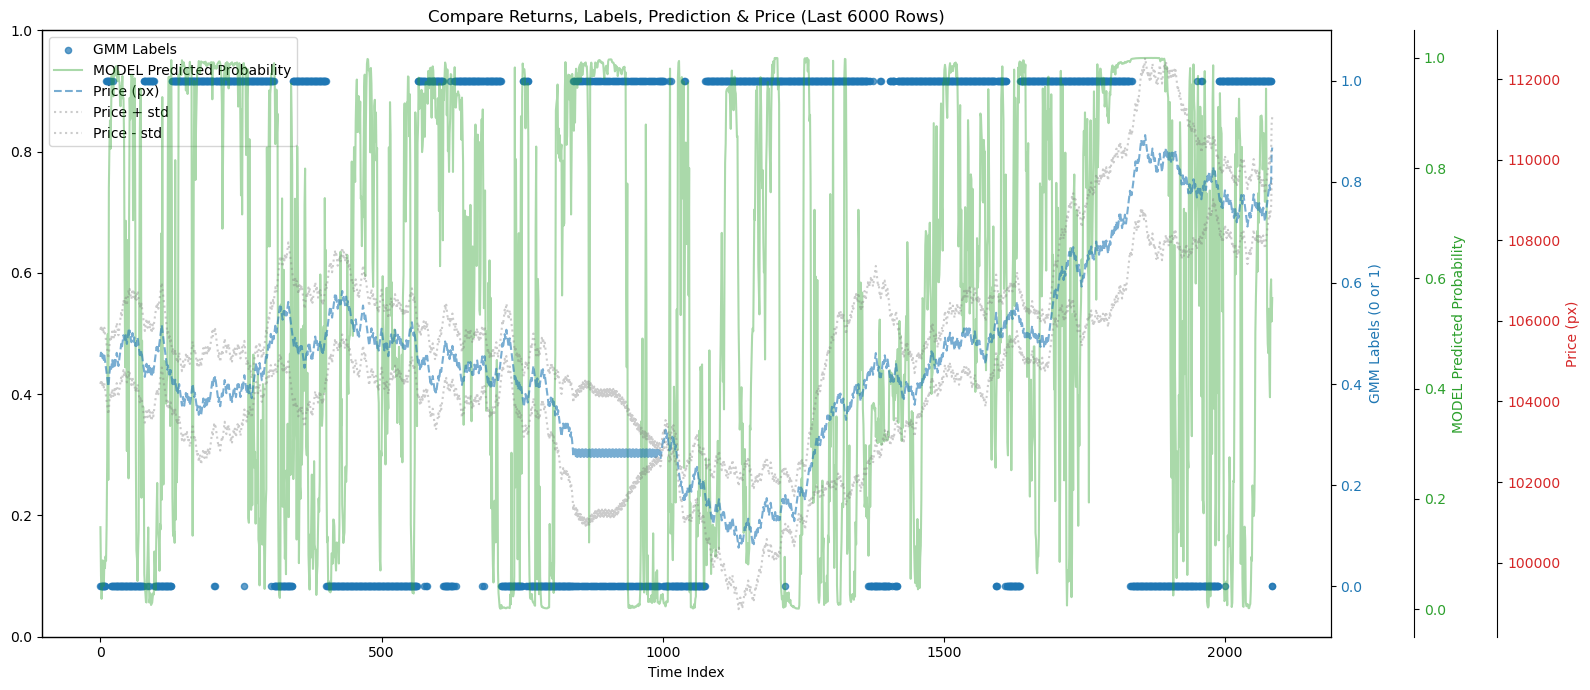

In [304]:
plot_last_n_rows_with_px(y_test, y_test, tabnet.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=6000, m=-1, alpha=alpha)


In [203]:
# LightGBM 训练
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    verbose=-1,
)
lgb_model.fit(X_train, y_train)

# 预测概率（后续画图用）
y_pred_prob = lgb_model.predict_proba(X_test)[:, 1]

# 性能评估
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))
print(classification_report(y_test, lgb_model.predict(X_test)))

ROC AUC: 0.5106704495113362
              precision    recall  f1-score   support

           0       0.47      0.24      0.32      3976
           1       0.50      0.74      0.60      4065

    accuracy                           0.49      8041
   macro avg       0.49      0.49      0.46      8041
weighted avg       0.49      0.49      0.46      8041



In [204]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
y_pred_prob = lgb_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# 评估测试集
print("Test Accuracy:", accuracy_score(y_test, y_pred_label))
print(classification_report(y_test, y_pred_label))
cm = confusion_matrix(y_test, y_pred_label)
print("Confusion Matrix:")
print(cm)
# 设置上下概率阈值
lower_thresh = 0.2
upper_thresh = 0.8

# 初始化标签为 -1（表示不出手）
y_pred_label = np.full_like(y_pred_prob, fill_value=-1, dtype=int)

# 预测为下跌（做空）
y_pred_label[y_pred_prob <= lower_thresh] = 0

# 预测为上涨（做多）
y_pred_label[y_pred_prob >= upper_thresh] = 1

# 筛选出模型明确给出方向的样本
mask = y_pred_label != -1

# 评估：只看模型明确判断的那部分（即“出手”的预测）
print("✅ Test Accuracy (Confident Predictions):", accuracy_score(y_test[mask], y_pred_label[mask]))
print("📊 Classification Report (Confident Predictions):")
print(classification_report(y_test[mask], y_pred_label[mask]))

print("🧮 Confusion Matrix (Confident Predictions):")
print(confusion_matrix(y_test[mask], y_pred_label[mask]))

# 出手率（模型愿意下单的比例）
print("📈 Trading Rate (Confident Predictions):", mask.mean())


Test Accuracy: 0.4929735107573685
              precision    recall  f1-score   support

           0       0.47      0.24      0.32      3976
           1       0.50      0.74      0.60      4065

    accuracy                           0.49      8041
   macro avg       0.49      0.49      0.46      8041
weighted avg       0.49      0.49      0.46      8041

Confusion Matrix:
[[ 959 3017]
 [1060 3005]]
✅ Test Accuracy (Confident Predictions): 0.5402409638554216
📊 Classification Report (Confident Predictions):
              precision    recall  f1-score   support

           0       0.84      0.05      0.10       995
           1       0.53      0.99      0.69      1080

    accuracy                           0.54      2075
   macro avg       0.68      0.52      0.39      2075
weighted avg       0.68      0.54      0.41      2075

🧮 Confusion Matrix (Confident Predictions):
[[  51  944]
 [  10 1070]]
📈 Trading Rate (Confident Predictions): 0.2580524810346972


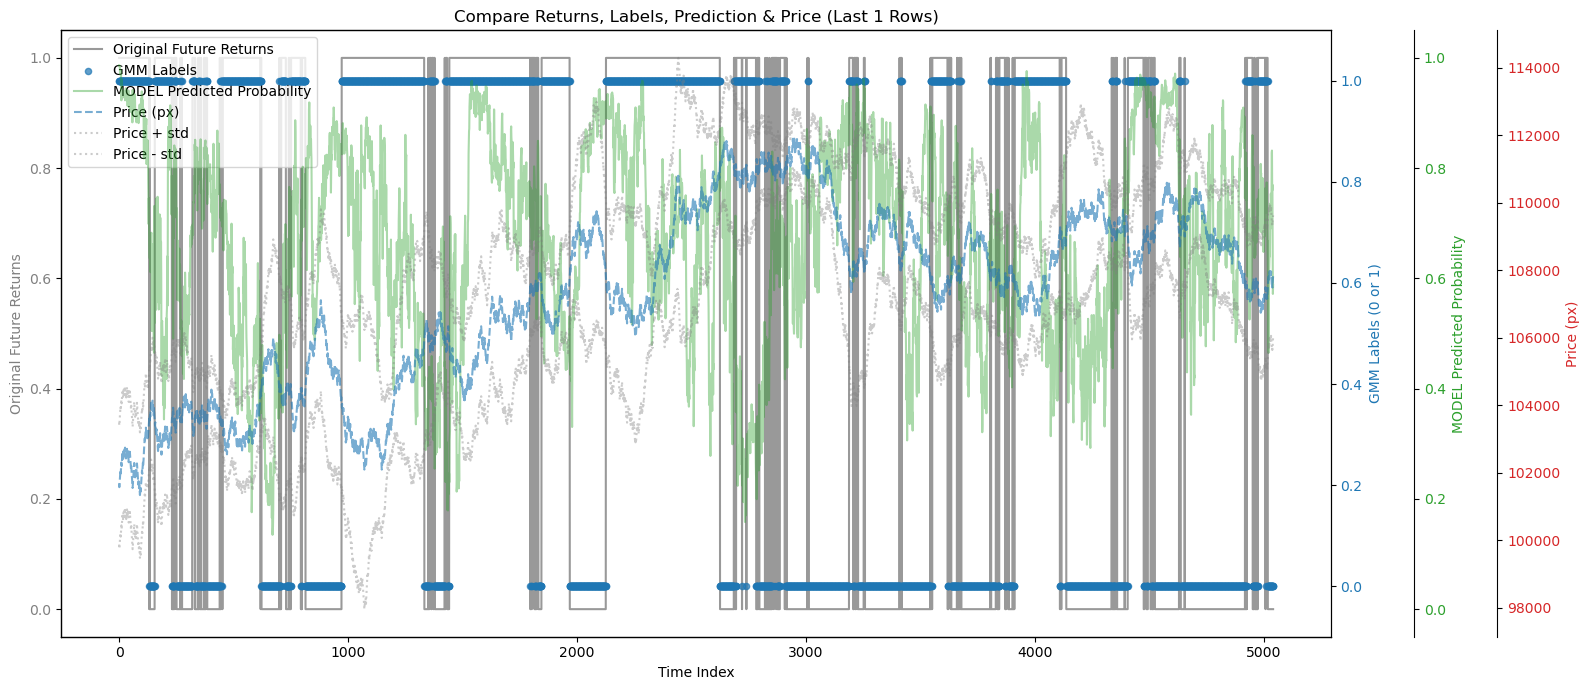

In [213]:
plot_last_n_rows_with_px(y_test, y_test, y_pred_prob, px_test, std_array=std_test, n=1, m=-3000, alpha=alpha)


In [187]:
def plot_last_n_rows_with_px(y_test, y_test_binary, y_pred_prob, px, std_array=None, n=700, m=-1, alpha=1):
    # 截取最后 n 行
    y_test_slice = y_test[n:m]
    y_test_binary_slice = y_test_binary[n:m]
    y_pred_prob_slice = y_pred_prob[n:m]
    px_slice = px[n:m]
    
    if std_array is not None:
        std_slice = std_array[n:m]
    else:
        std_slice = None

    time_index = np.arange(len(y_test_slice))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # 原始收益
    ax1.plot(time_index, y_test_slice, label="Original Future Returns", color='gray', alpha=0.8)
    ax1.set_ylabel("Original Future Returns", color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')

    # GMM 标签
    ax2 = ax1.twinx()
    ax2.scatter(time_index, y_test_binary_slice, label="GMM Labels", color='tab:blue', marker='o', s=20, alpha=0.7)
    ax2.set_ylabel("GMM Labels (0 or 1)", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(-0.1, 1.1)

    # 模型预测概率
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(time_index, y_pred_prob_slice, label="MODEL Predicted Probability", color='tab:green', alpha=0.4)
    ax3.set_ylabel("MODEL Predicted Probability", color='tab:green')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.set_ylim(-0.05, 1.05)

    # 价格线 (第4轴)
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))  # 再右移一层
    ax4.plot(time_index, px_slice, label="Price (px)", color='tab:blue', linestyle='--', alpha=0.6)

    # 加上下轨线
    if std_slice is not None:
        ax4.plot(time_index, px_slice + alpha * std_slice, label="Price + std", color='tab:gray', linestyle=':', alpha=0.4)
        ax4.plot(time_index, px_slice - alpha * std_slice, label="Price - std", color='tab:gray', linestyle=':', alpha=0.4)

    ax4.set_ylabel("Price (px)", color='tab:red')
    ax4.tick_params(axis='y', labelcolor='tab:red')

    # x轴
    ax1.set_xlabel("Time Index")
    plt.title(f"Compare Returns, Labels, Prediction & Price (Last {n} Rows)")

    # 图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    lines_4, labels_4 = ax4.get_legend_handles_labels()

    ax1.legend(
        lines_1 + lines_2 + lines_3 + lines_4,
        labels_1 + labels_2 + labels_3 + labels_4,
        loc='upper left'
    )

    plt.tight_layout()
    plt.show()
